In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
import hdf5plugin
from tqdm import tqdm

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)

import urllib
import pycountry

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

no config found


In [2]:
ds = xr.open_dataset('../trajectory/netcdf_files_lnsp/202001010000_chunked_file.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:           (latitude: 640, longitude: 1280)
Coordinates:
    number            int64 ...
    time              datetime64[ns] ...
    step              timedelta64[ns] ...
    entireAtmosphere  int64 ...
  * latitude          (latitude) float64 89.78 89.51 89.23 ... -89.51 -89.78
  * longitude         (longitude) float64 0.0 0.2813 0.5625 ... 359.4 359.7
    valid_time        datetime64[ns] ...
Data variables:
    lnsp              (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-02-23T12:52:05 GRIB to CDM+CF via cfgrib-0....

In [2]:
import ray
import time
ray.init(num_cpus=10)

2023-03-10 11:34:07,763	INFO worker.py:1528 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.10.6', ray_version='2.1.0', ray_commit='be49bde7ee4f6adb3f8710aee0665c27f9f0bb62', address_info={'node_ip_address': '131.130.157.11', 'raylet_ip_address': '131.130.157.11', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2023-03-10_11-34-03_268267_3969604/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2023-03-10_11-34-03_268267_3969604/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2023-03-10_11-34-03_268267_3969604', 'metrics_export_port': 52982, 'gcs_address': '131.130.157.11:55857', 'address': '131.130.157.11:55857', 'dashboard_agent_listen_port': 52365, 'node_id': '588812663b9af4b04a726bf9d86dd405cd895b1bf06bbc5020586c58'})

In [3]:
@ray.remote
def trend_station(i):
    sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
    import rasotools
    df_dict = {}
    sout = []
    aout = []
    stats = []
    lats = []
    lons = []
    start = 1993
    end = 2023
    intervall = end - start
    dt_from = datetime_to_seconds(np.datetime64('1993-01-01'))
    dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))
    
    try:
        # multiprocessing here
        with h5py.File(i, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            plevs = [70000]

            idx_d = {}
            # var_d = {'air_temperature':'126', 'relative_humidty':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
            var_d = {'relative_humidty':'138'}
            for i in var_d:
                idx_d[i] = file['recordindices'][var_d[i]][idx]

            masks = {}
            for i in idx_d:
                masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
                masks[i] = np.isin(masks[i],plevs)
                # masks[i] = np.isfinite(masks[i])

            mask = masks['relative_humidty']
            t_idx = idx_d['relative_humidty']
            df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
            df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['humidity_bias_estimate'] = list(file['advanced_homogenisation']['humidity_bias_estimate'][t_idx[0]:t_idx[-1]][mask])

            temp = pd.DataFrame.from_dict(df_dict)
            # display(temp)

            if len(temp) > 0:
                # temp.sort_values('time')
                temp['time'] = pd.to_datetime(temp['date_time'])
                temp['lat'] = numpy.array([temp.latitude.iloc[-1]]*len(temp))
                temp['lon'] = numpy.array([temp.longitude.iloc[-1]]*len(temp))
                temp['adjusted'] = temp['observation_value'] - temp['humidity_bias_estimate']
                temptime = temp.time
                if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                    # print('enough data')
                    xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                    # and do it twice for the adjusted values too!
                    out = rasotools.met.time.trend(xa.observation_value,only_slopes=True).to_dataframe(name='out')
                    sout.append(float(out.iloc[-1] *3650))
                    out_adj = rasotools.met.time.trend(xa.adjusted,only_slopes=True).to_dataframe(name='out_adj')
                    aout.append(float(out_adj.iloc[-1] *3650))
                else:
                    sout=np.nan
                    aout=np.nan
            else:
                sout=np.nan
                aout=np.nan
            try:
                lats=temp.latitude.iloc[-1]
                lons=temp.longitude.iloc[-1]
                stats=i
            except:
                lats=np.nan
                lons=np.nan
                stats=i
    except:
        lats=np.nan
        lons=np.nan
        stats=i
        sout=np.nan
        aout=np.nan
    return [stats, lats, lons, sout, aout]

In [4]:
result_ids = []
for i in glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*.nc'):
    result_ids.append(trend_station.remote(i))

# Wait for the tasks to complete and retrieve the results.
# With at least 4 cores, this will take 1 second.
results = ray.get(result_ids)
pickle.dump( results, open( "trends_700hPa_1993_2023_Trend.p", "wb" ))
ray.shutdown()

In [30]:
good_results = {}
good_results['lat'] = []
good_results['lon'] = []
good_results['st'] = []
good_results['at'] = []
good_results['label'] = []
results = pickle.load(open('test_trends_700hPa_1993_2023_Trend.p', 'rb'))
for i in results:
    badflag = 0
    for j in i:
        try:
            if np.isnan(j):
                badflag = 1
        except:
            pass
    if badflag == 0:
        good_results['lat'].append(i[1])
        good_results['lon'].append(i[2])
        good_results['st'].append(i[3][0])
        good_results['at'].append(i[4][0])
        good_results['label'].append(i[0].split('/')[-1].split('_')[0])
good_results

{'lat': [67.2851, 62.53176],
 'lon': [14.4542, 17.43608],
 'st': [0.016170769153722116, 0.011507547331240493],
 'at': [0.016170769153722116, 0.0059959273120665695],
 'label': ['0-20000-0-01152', '0-20000-0-02365']}

In [ ]:
good_results

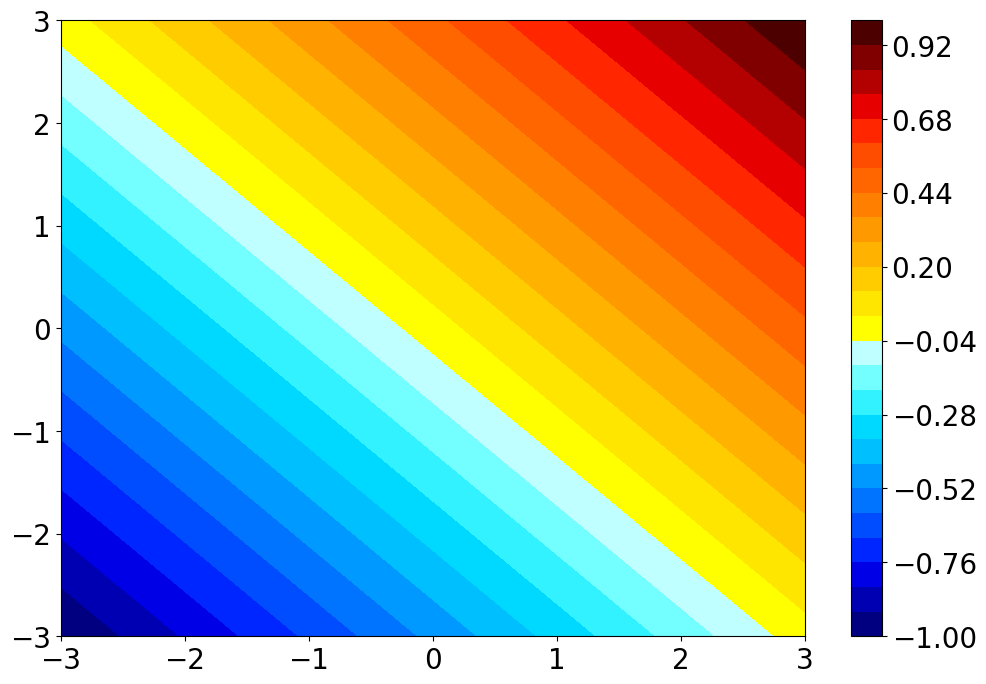

ready


AttributeError: 'list' object has no attribute 'split'

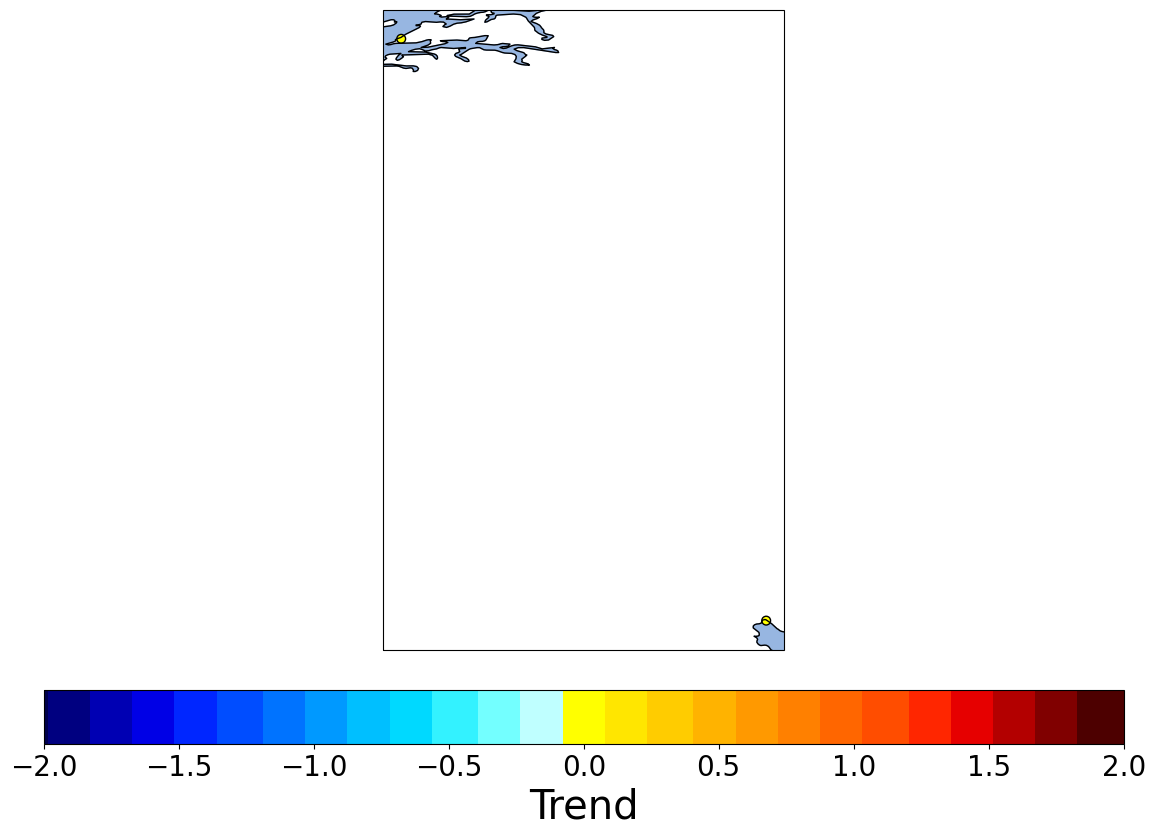

In [40]:
# def plt_trends(i):
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools
import cartopy.crs as ccrs
import cartopy.feature as cfeature

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 20,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
matplotlib.pylab.rcParams.update(params)

# import matplotlib.pylab as plt
# import matplotlib.colors as mcolors
# import numpy

# def rgb(r,g,b):
#     return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

# def make_colormap(seq):
#     """Return a LinearSegmentedColormap
#     seq: a sequence of floats and RGB-tuples. The floats should be increasing
#     and in the interval (0,1).
#     """
#     se = [(None,) * 3, 0.0]
#     for s in seq:
#         se.append(s[0])
#         se.append(s[1])#+ list(seq) +
#         seq=se+[ (None,) * 3]
#         cdict = {'red': [], 'green': [], 'blue': []}
#         for i, item in enumerate(seq):
#             if isinstance(item, float):
#                 r1, g1, b1 = seq[i - 1]
#                 r2, g2, b2 = seq[i + 1]
#                 cdict['red'].append([item, r1, r2])
#                 cdict['green'].append([item, g1, g2])
#                 cdict['blue'].append([item, b1, b2])
#     return mcolors.LinearSegmentedColormap('CustomMap', cdict)

# rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
# "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
# "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
# "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
# "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
# "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
# "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
# "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
# "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
# rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

# cmnew=make_colormap(rgblist2)

# x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
# gauss=x/6+y/6
# clist=numpy.linspace(-1,1,26)
# plt.contourf(x,y,gauss,clist,cmap=cmnew)
# plt.colorbar()
# plt.show()
# print('ready')


good_results = {}
good_results['lat'] = []
good_results['lon'] = []
good_results['st'] = []
good_results['at'] = []
good_results['label'] = []
results = pickle.load(open('test_trends_700hPa_1993_2023_Trend.p', 'rb'))
for i in results:
    badflag = 0
    for j in i:
        try:
            if np.isnan(j):
                badflag = 1
        except:
            pass
    if badflag == 0:
        good_results['lat'].append(i[1])
        good_results['lon'].append(i[2])
        good_results['st'].append(i[3][0])
        good_results['at'].append(i[4][0])
        good_results['label'].append(i[0].split('/')[-1].split('_')[0])
da = pd.DataFrame.from_dict(good_results)

statnum = len(da)
a = rasotools.plot._helpers.cost(np.asarray(da.lon), np.asarray(da.lat), np.asarray(da.st))
cost = np.sum(a)/len(a)

ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.coastlines()

reduced = np.asarray(da['st'])
longitudes = list(da['lon'])
latitudes = list(da['lat'])
plt.scatter(longitudes, latitudes, s=40, alpha=1,
            c= da['st'],
            cmap=cmnew,
            vmin=-2,
            vmax=2,
            edgecolor='k',)
plt.colorbar(orientation='horizontal', label='Trend', shrink=0.9, pad=0.05)
plt.tight_layout()
#     plt.title('CUAN'+i.split('.')[0][4:]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
#     plt.savefig('plots/'+'CUAN'+i[4:]+'ng', bbox_inches='tight')
plt.title(i.split('.')[0]+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(statnum))
plt.show()
plt.savefig('plots_new/'+i+'ng', bbox_inches='tight')
plt.close()

In [37]:
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools


stations = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*.nc')



def trend_station(i):
    sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
    import rasotools
    df_dict = {}
    sout = []
    aout = []
    stats = []
    lats = []
    lons = []
    start = 1993
    end = 2023
    intervall = end - start
    dt_from = datetime_to_seconds(np.datetime64('1993-01-01'))
    dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))
    
    try:
        # multiprocessing here
        with h5py.File(i, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            plevs = [70000]

            idx_d = {}
            # var_d = {'air_temperature':'126', 'relative_humidty':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
            var_d = {'relative_humidty':'138'}
            for i in var_d:
                idx_d[i] = file['recordindices'][var_d[i]][idx]

            masks = {}
            for i in idx_d:
                masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
                masks[i] = np.isin(masks[i],plevs)
                # masks[i] = np.isfinite(masks[i])

            mask = masks['relative_humidty']
            t_idx = idx_d['relative_humidty']
            df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
            df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['humidity_bias_estimate'] = list(file['advanced_homogenisation']['humidity_bias_estimate'][t_idx[0]:t_idx[-1]][mask])

            temp = pd.DataFrame.from_dict(df_dict)
            # display(temp)

            if len(temp) > 0:
                # temp.sort_values('time')
                temp['time'] = pd.to_datetime(temp['date_time'])
                temp['lat'] = numpy.array([temp.latitude.iloc[-1]]*len(temp))
                temp['lon'] = numpy.array([temp.longitude.iloc[-1]]*len(temp))
                temp['adjusted'] = temp['observation_value'] - temp['humidity_bias_estimate']
                temptime = temp.time
                if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                    # print('enough data')
                    xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                    # and do it twice for the adjusted values too!
                    out = rasotools.met.time.trend(xa.observation_value,only_slopes=True).to_dataframe(name='out')
                    sout.append(float(out.iloc[-1] *3650))
                    out_adj = rasotools.met.time.trend(xa.adjusted,only_slopes=True).to_dataframe(name='out_adj')
                    aout.append(float(out_adj.iloc[-1] *3650))
                else:
                    sout=np.nan
                    aout=np.nan
            else:
                sout=np.nan
                aout=np.nan
            try:
                lats=temp.latitude.iloc[-1]
                lons=temp.longitude.iloc[-1]
                stats=i
            except:
                lats=np.nan
                lons=np.nan
                stats=i
    except:
        lats=np.nan
        lons=np.nan
        stats=i
        sout=np.nan
        aout=np.nan
    return [stats, lats, lons, sout, aout]


pickle.dump( aout, open( "aout_700hPa_1993_2023_Trend.p", "wb" ))

NameError: name 'aout' is not defined

In [ ]:
sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools


from ipywidgets import IntProgress
from IPython.display import display


stations = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*.nc')
sout = []
aout = []
stats = []
lats = []
lons = []
start = 1993
end = 2023
intervall = end - start
dt_from = datetime_to_seconds(np.datetime64('1993-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

max_count = len(stations)
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for i in stations:
    df_dict = {}
    try:
        # multiprocessing here
        with h5py.File(i, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            plevs = [70000]

            idx_d = {}
            # var_d = {'air_temperature':'126', 'relative_humidty':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
            var_d = {'relative_humidty':'138'}
            for i in var_d:
                idx_d[i] = file['recordindices'][var_d[i]][idx]

            masks = {}
            for i in idx_d:
                masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
                masks[i] = np.isin(masks[i],plevs)
                # masks[i] = np.isfinite(masks[i])

            mask = masks['relative_humidty']
            t_idx = idx_d['relative_humidty']
            df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
            df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
            df_dict['humidity_bias_estimate'] = list(file['advanced_homogenisation']['humidity_bias_estimate'][t_idx[0]:t_idx[-1]][mask])

            temp = pd.DataFrame.from_dict(df_dict)
            # display(temp)

            if len(temp) > 0:
                # temp.sort_values('time')
                temp['time'] = pd.to_datetime(temp['date_time'])
                temp['lat'] = numpy.array([temp.latitude.iloc[-1]]*len(temp))
                temp['lon'] = numpy.array([temp.longitude.iloc[-1]]*len(temp))
                temp['adjusted'] = temp['observation_value'] - temp['humidity_bias_estimate']
                temptime = temp.time
                if len(temp) >= 19*365 and len(numpy.unique(temptime.dt.year)) > 19 :
                    # print('enough data')
                    xa = temp.set_index(['lat', 'lon', 'time']).to_xarray()
                    # and do it twice for the adjusted values too!
                    out = rasotools.met.time.trend(xa.observation_value,only_slopes=True).to_dataframe(name='out')
                    sout.append(float(out.iloc[-1] *3650))
                    out_adj = rasotools.met.time.trend(xa.adjusted,only_slopes=True).to_dataframe(name='out_adj')
                    aout.append(float(out_adj.iloc[-1] *3650))
                else:
                    sout.append(np.nan)
                    aout.append(np.nan)
            else:
                sout.append(np.nan) 
                aout.append(np.nan)
            try:
                lats.append(temp.latitude.iloc[-1])
                lons.append(temp.longitude.iloc[-1])
                stats.append(i)
            except:
                lats.append(np.nan)
                lons.append(np.nan)
                stats.append(i)
    except:
        lats.append(np.nan)
        lons.append(np.nan)
        stats.append(i)
        sout.append(np.nan)
        aout.append(np.nan)
    f.value += 1
pickle.dump( lats, open( "lats_700hPa_1993_2023_Trend.p", "wb" ))
pickle.dump( lons, open( "lons_700hPa_1993_2023_Trend.p", "wb" ))
pickle.dump( stats, open( "stats_700hPa_1993_2023_Trend.p", "wb" ))
pickle.dump( sout, open( "sout_700hPa_1993_2023_Trend.p", "wb" ))
pickle.dump( aout, open( "aout_700hPa_1993_2023_Trend.p", "wb" ))

IntProgress(value=0, max=12008)

In [60]:
sout

[-0.0003397024741970607]

In [24]:
print(istart)
print(seconds_to_datetime(istart))

1435708800.0
1945-07-01 00:00:00


In [43]:
import hdf5plugin
import h5py
import numpy as np
import os,glob,sys
import datetime

miss=glob.glob(os.path.expandvars('/mnt/users/scratch/leo/scratch/converted_v11/long/*12812*v1.nc'))
nmiss=[]
for m in miss:
    key=m.split('_CEUAS')[0].split('-')[-1]
    fns=[m]#glob.glob(os.path.expandvars('$RSCRATCH/converted_v11/long/*'+m+'*v1.nc'))
    
    dt_from = datetime_to_seconds(np.datetime64('1945-02-02'))
    dt_to = datetime_to_seconds(np.datetime64('1945-12-31'))
    
    
    for fn in fns:
        
        with h5py.File(fn,'r') as g:
            rts = g['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]

            if len(idx)>0:
                # try:
                ridxu=g['recordindices']['139'][idx[0]:idx[-1]]
                ridxv=g['recordindices']['140'][idx[0]:idx[-1]]
                if ridxu[0]==ridxu[-1]:
                    continue
                if 'wind_bias_estimate' not in g['advanced_homogenisation'].keys():
                    continue
                print('u','/'.join(m.split('/')[-2:]), np.count_nonzero(~np.isnan(g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[-1]])))
                display(g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[0]+10])
                print('v','/'.join(m.split('/')[-2:]), np.count_nonzero(~np.isnan(g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[-1]])))
                display(g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[0]+10])
                display(g['observations_table/date_time'][ridxv[0]:ridxv[0]+10])
                print()
                    
                    #                     idy=np.arange(len(ridxu),dtype=int)

                                  
#                     if np.nanmean( g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[-1]][idy[0]])>0.1 or np.nanmean( g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[-1]][idy[0]])>0.1:
#                         print(ref+datetime.timedelta(seconds=int(g['observations_table/date_time'][ridxu[0]])),
#                               list(zip(g['observations_table/z_coordinate'][ridxu[0]:ridxu[-1]][idy],
#                                   g['observations_table/z_coordinate_type'][ridxu[0]:ridxu[-1]][idy],
#                                   g['observations_table/observation_value'][ridxu[0]:ridxu[-1]][idy],
#                                   g['observations_table/observation_value'][ridxv[0]:ridxv[-1]][idy],
#                                   g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[-1]][idy],
#                                   g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[-1]][idy])))

                    # if np.isnan(g['observations_table/z_coordinate'][ridx[0]:ridx[-1]][idy[0]]):
                    #     nmiss.append(g.filename)
                    #     break
                # except :
                #     print('could not read',m)
                #     print()

print(nmiss)

u long/0-20000-0-12812_CEUAS_merged_v1.nc 1435


array([ 2.8467126e-09, -0.0000000e+00,  2.6718908e-24, -5.6934244e-09,
        2.6718908e-24,  1.2772522e-07, -2.3647530e-07,  2.5207253e-08,
       -5.1707755e-08, -3.9359310e-08], dtype=float32)

v long/0-20000-0-12812_CEUAS_merged_v1.nc 1435


array([ 2.8467131e-09, -0.0000000e+00, -0.0000000e+00, -5.6934262e-09,
       -0.0000000e+00, -4.4088236e-07,  2.3647530e-07,  2.4620345e-08,
        1.8960155e-07,  3.5728732e-08], dtype=float32)

array([1422849600, 1422849600, 1422849600, 1422849600, 1422849600,
       1422892800, 1422892800, 1422892800, 1422892800, 1422892800])


[]


In [12]:
import hdf5plugin
import h5py
import numpy as np
import os,glob,sys
import datetime

miss=glob.glob(os.path.expandvars('/mnt/users/scratch/leo/scratch/converted_v11/long/*v1.nc'))
nmiss=[]
for m in miss:
    key=m.split('_CEUAS')[0].split('-')[-1]
    #print(key)
    #print(m)
    fns=[m]#glob.glob(os.path.expandvars('$RSCRATCH/converted_v11/long/*'+m+'*v1.nc'))
    #fns=glob.glob(os.path.expandvars('/mnt/scratch/scratch/federico/MERGED_FEB*/'+os.path.basename(m)))
    #fns=glob.glob(os.path.expandvars('/mnt/scratch/scratch/federico/COP2_HARVEST_JAN2023/*/*'+key+'*.nc'))
    #print(fns)

    ref=datetime.datetime(1900,1,1)
    dstart=datetime.datetime(1945,7,1)
    istart=(dstart-ref).total_seconds()
    
    for fn in fns:
        with h5py.File(fn,'r') as g:
                #print(g.filename,g.keys())
                idx=np.where(np.abs(g['recordindices/recordtimestamp'][:]-istart)<8640000)[0]
                
                if len(idx)>0:
                    try:
                        ridxu=g['recordindices']['139'][idx[0]:idx[0]+2]
                        ridxv=g['recordindices']['140'][idx[0]:idx[0]+2]
                        print('/'.join(m.split('/')[-2:]),ridxu)
                        if ridxu[0]==ridxu[-1]:
                            continue
                        idy=np.arange(len(ridxu),dtype=int)
                        if 'wind_bias_estimate' not in g['advanced_homogenisation'].keys():
                            continue
                        if np.nanmean( g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[-1]][idy[0]])>0.1 or np.nanmean( g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[-1]][idy[0]])>0.1:
                            print(ref+datetime.timedelta(seconds=int(g['observations_table/date_time'][ridxu[0]])),
                                  list(zip(g['observations_table/z_coordinate'][ridxu[0]:ridxu[-1]][idy],
                                      g['observations_table/z_coordinate_type'][ridxu[0]:ridxu[-1]][idy],
                                      g['observations_table/observation_value'][ridxu[0]:ridxu[-1]][idy],
                                      g['observations_table/observation_value'][ridxv[0]:ridxv[-1]][idy],
                                      g['advanced_homogenisation/wind_bias_estimate'][ridxu[0]:ridxu[-1]][idy],
                                      g['advanced_homogenisation/wind_bias_estimate'][ridxv[0]:ridxv[-1]][idy])))

                        # if np.isnan(g['observations_table/z_coordinate'][ridx[0]:ridx[-1]][idy[0]]):
                        #     nmiss.append(g.filename)
                        #     break
                    except :
                        print('could not read',m)
        
print(nmiss)

long/0-20000-0-74793_CEUAS_merged_v1.nc [32772 32792]
long/0-20000-0-71912_CEUAS_merged_v1.nc [23577 23583]
long/0-20000-0-74787_CEUAS_merged_v1.nc [17061 17066]
long/0-20000-0-74791_CEUAS_merged_v1.nc [57973 57980]
long/0-20000-0-71868_CEUAS_merged_v1.nc [29899 29907]
long/0-20000-0-74754_CEUAS_merged_v1.nc [117267 117279]
long/0-20000-0-74783_CEUAS_merged_v1.nc [26907 26911]
long/0-20000-0-71807_CEUAS_merged_v1.nc [1830084 1830089]
long/0-20000-0-74718_CEUAS_merged_v1.nc [195353 195357]
long/0-20000-0-70414_CEUAS_merged_v1.nc [7904729 7904741]
long/0-20000-0-74724_CEUAS_merged_v1.nc [33746 33766]
long/0-20000-0-74492_CEUAS_merged_v1.nc [48722 48724]
long/0-20000-0-47741_CEUAS_merged_v1.nc [84163572 84163575]
long/0-20000-0-72326_CEUAS_merged_v1.nc [1209803 1209811]
long/0-20000-0-74491_CEUAS_merged_v1.nc [76869 76874]
long/0-20000-0-74480_CEUAS_merged_v1.nc [733910 733916]
long/0-20000-0-72308_CEUAS_merged_v1.nc [4207276 4207279]
long/0-20000-0-74490_CEUAS_merged_v1.nc [34856 34860]


In [5]:
miss

[]

In [19]:
# rq={'observed_variable': ['air_temperature', 'dew_point_temperature'],'year': '1980', 'month': '06', 'day': '01', 'format': 'nc',}
# 'dest_0-20000-0-48477_air_temperature.nc' ['1980-03-03T12:00:00.000000000']
# 'dest_0-20000-0-95966_air_temperature.nc' ['1977-05-07T12:00:00.000000000']
# 'dest_0-20000-0-95966_dew_point_temperature.nc' ['1970-11-01T17:00:00.000000000']

stat = '95966'
# conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*'+str(stat)+'*_CEUAS_merged_v1.nc')[0]
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/*'+str(stat)+'*_CEUAS_merged_v1.nc')[0]
# conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*'+str(stat)+'*_CEUAS_merged_v1.nc')[0]

dt_from = datetime_to_seconds(np.datetime64('1980-06-01'))
dt_to = datetime_to_seconds(np.datetime64('1980-06-02'))

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    idx_d = {}
    # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
    var_d = {'air_temperature':'126'}
    for i in var_d:
        idx_d[i] = file['recordindices'][var_d[i]][idx]

    masks = {}
    for i in idx_d:
        masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
        masks[i] = np.isin(masks[i],plevs)
        masks[i] = np.isfinite(masks[i])

    mask = masks['air_temperature']
    t_idx = idx_d['air_temperature']
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
    df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
df = pd.DataFrame.from_dict(df_dict)
df

z_coordinate           date_time  air_temperature
0       88200.0 1977-05-07 12:00:00       268.049988
1       91500.0 1977-05-07 12:00:00       266.450012
2      100000.0 1977-05-07 12:00:00       271.850006
3      100400.0 1977-05-07 12:00:00       272.049988

In [83]:
statid = '0-20100*'
pat=statid[:statid.index('*')]
print(pat)

with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as json_file:
    data = json.load(json_file)
    
slnum = list(data.keys())

# stats = []    
# for l in slnum: # -> searches all slnum for matching statids
#     if pat in l: 
#         stats.append(l)
# print(stats)
list(filter(lambda x: '0-20300' in x, slnum))

0-20100


['0-20300-0-13942',
 '0-20300-0-13839',
 '0-20300-0-13850',
 '0-20300-0-14723',
 '0-20300-0-12920',
 '0-20300-0-13851',
 '0-20300-0-62056',
 '0-20300-0-04876',
 '0-20300-0-62002',
 '0-20300-0-14719',
 '0-20300-0-03995',
 '0-20300-0-59431',
 '0-20300-0-04977',
 '0-20300-0-62010',
 '0-20300-0-94763',
 '0-20300-0-72798',
 '0-20300-0-93871',
 '0-20300-0-93072',
 '0-20300-0-03751',
 '0-20300-0-03671',
 '0-20300-0-13937',
 '0-20300-0-96853',
 '0-20300-0-74724',
 '0-20300-0-52313',
 '0-20300-0-60678',
 '0-20300-0-21965',
 '0-20300-0-53420',
 '0-20300-0-03509',
 '0-20300-0-03322',
 '0-20300-0-03123',
 '0-20300-0-03134',
 '0-20300-0-63694',
 '0-20300-0-48867',
 '0-20300-0-13859',
 '0-20300-0-48864',
 '0-20300-0-48851',
 '0-20300-0-46780',
 '0-20300-0-12881',
 '0-20300-0-99276',
 '0-20300-0-63710',
 '0-20300-0-13924',
 '0-20300-0-99010',
 '0-20300-0-35361',
 '0-20300-0-25954',
 '0-20300-0-13715',
 '0-20300-0-23213',
 '0-20300-0-99013',
 '0-20300-0-99286',
 '0-20300-0-13923',
 '0-20300-0-13856',


In [55]:
conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*11035*_CEUAS_merged_v1.nc')[0]
dt_from = datetime_to_seconds(np.datetime64('2022-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    print(list(file.keys()))
    print(list(file['recordindices'].keys()))
    print(list(file['advanced_homogenisation'].keys()))
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    idx_d = {}
    # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
    var_d = {'air_temperature':'126'}
    for i in var_d:
        idx_d[i] = file['recordindices'][var_d[i]][idx]

    masks = {}
    for i in idx_d:
        print(len(file['observations_table']['z_coordinate'][:]))
        print([idx_d[i][0], idx_d[i][-1]])
        masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
        masks[i] = np.isin(masks[i],plevs)
        masks[i] = np.isfinite(masks[i])

    mask = masks['air_temperature']
    t_idx = idx_d['air_temperature']
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
    df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
df_old = pd.DataFrame.from_dict(df_dict)
display(df_old)
# for i in plevs:
#     df_plev = df_old[df_old.z_coordinate == i]
#     plt.plot(df_plev.date_time, df_plev.air_temperature, color = 'blue', linewidth = 1, alpha = 1, label='temp')
#     plt.plot(df_plev.date_time, (df_plev.air_temperature - df_plev.RAOBCORE_bias_estimate), color = 'green', linewidth = 3, alpha = 0.5, label='raobcore_temp')

#     ax = plt.gca()
#     ax.set_ylim(ax.get_ylim()[::-1])

#     plt.title(str(i) + ' Pa')
#     plt.ylabel('temperature [K]')
#     plt.xlabel('date_time [1]')
#     plt.grid()
#     plt.legend()
#     plt.show()
#     plt.close()

['advanced_homogenisation', 'crs', 'era5fb', 'header_table', 'observations_table', 'observed_variable', 'recordindices', 'sensor_configuration', 'source_configuration', 'station_configuration', 'station_configuration_codes', 'station_type', 'units', 'z_coordinate_type']
['0', '106', '107', '117', '126', '137', '138', '139', '140', '34', '39', 'index', 'recordtimestamp']
['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate', 'humidity_bias_estimate', 'index', 'wind_bias_estimate']
115828893
[61705070, 64752479]


z_coordinate           date_time  RAOBCORE_bias_estimate  \
0               760.0 2022-01-01 11:33:34                     NaN   
1               770.0 2022-01-01 11:33:34                     NaN   
2               780.0 2022-01-01 11:33:34                     NaN   
3               790.0 2022-01-01 11:33:34                     NaN   
4               800.0 2022-01-01 11:33:34                     NaN   
...               ...                 ...                     ...   
3047404       99030.0 2022-12-30 11:30:41                0.462920   
3047405       99130.0 2022-12-30 11:30:41                0.471559   
3047406       99200.0 2022-12-30 11:30:41                0.477606   
3047407       99300.0 2022-12-30 11:30:41                0.486245   
3047408       99680.0 2022-12-30 11:30:41                0.519072   

         air_temperature  
0             245.139999  
1             244.029999  
2             242.309998  
3             240.690002  
4             239.720001  
...                  ...  
3047404       274.910004  
3047405       274.980011  
3047406       275.119995  
3047407       275.390015  
3047408       276.149994  

[3047409 rows x 4 columns]

In [47]:
conv_file

'/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02260_CEUAS_merged_v1.nc'

In [36]:
dt_from = datetime_to_seconds(np.datetime64('1900-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

df_dict = {}
h_df_dict = {}
for i in ['97192', '91413', '91165', '70219', '47741', '13275', '06610', '02365']:
    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*'+str(i)+'*_CEUAS_merged_v1.nc')[0]
    with h5py.File(conv_file, 'r') as file:
        rts = (file['header_table']['report_timestamp'][:])
        rct = (file['header_table']['record_timestamp'][:])
        print(i)
        print(np.min(rts))
        print(np.max(rts))
        print(np.min(rct))
        print(np.max(rct))
#     rts = file['recordindices']['recordtimestamp'][:]
#     idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
#     plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
#     idx_d = {}
#     # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
#     var_d = {'air_temperature':'126'}
#     for i in var_d:
#         idx_d[i] = file['recordindices'][var_d[i]][idx]

#     masks = {}
#     for i in idx_d:
#         masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
#         masks[i] = np.isin(masks[i],plevs)
#         masks[i] = np.isfinite(masks[i])

#     mask = masks['air_temperature']
#     t_idx = idx_d['air_temperature']
#     df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
#     df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
#     df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
#     df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])


97192
0
3881347200
2890620000
3881347200
91413
0
3881473787
1541732400
3881473787
91165
0
3881473537
1264791600
3881473537
70219
0
3881473266
1287439200
3881473266
47741
-9223372036854775808
3881475124
1088557200
3881475124
13275
0
3881495760
1735790400
3881495760
06610
-9223372036854775808
3881473207
1332687600
3881473207
02365
-9223372036854775808
3881431803
2071137600
3881431803


In [27]:
np.min(rts)

0

In [3]:
def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
           grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
           data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
    """ Plot stations on a map

    Args:
        lon (np.array, list): Longitudes
        lat (np.array, list): Latidutes
        labels (np.array, list): Labels
        values (np.array, list): Values for scatterplot
        markersize (int): markersize
        ocean (bool): plot ocean ?
        land (bool): plot land ?
        coastlines (bool): plot coastlines ?
        rivers (bool): plot river ?
        grid (bool): plot gridlines ?
        posneg (bool): different markers for positive and negative
        extent (str): neither (default), both, min, max
        lloffset (float): label offset
        showcost (bool): Estimate Cost function and add to title
        clabel (str): Colorbar Label
        cbars (dict): Colorbar Options
        colorlevels (list, str): scatterplot colorlevels
        data (xr.DataArray): Data
        vmin (float): minimum value
        vmax (float): maximum value
        dropna (bool): Remove missing values?
        figure (plt.figure): figure handle
        gridspecs (dict): gridspec options for figure
        **kwargs:

    Returns:
        plt.axes
    """
    import numpy as np
    import cartopy as cpy
    from matplotlib.colors import BoundaryNorm
    import matplotlib.pyplot as plt
#     from ._helpers import cost, plot_arange as pa, plot_levels as pl

    if data is not None:
        lon = data[lon]
        lat = data[lat]
        values = data

    lon = np.asarray(lon)
    lat = np.asarray(lat)

    if lon.size != lat.size:
        raise ValueError("Lon and Lat need same size")

    if values is not None:
        values = np.asarray(values, dtype=float)
        nn = np.size(values)
        if lon.size != lat.size or lon.size != values.size:
            raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

        if vmin is not None:
            idx = values < vmin
            values[idx] = np.nan
            print("vmin", idx.sum(), nn)

        if vmax is not None:
            idx = values > vmax
            values[idx] = np.nan
            print("vmax", idx.sum(), nn)

        if dropna:
            idx = np.isfinite(values)
            values = values[idx]
            lon = lon[idx]
            lat = lat[idx]
            print("NA", nn - idx.sum(), nn)

    projection = kwargs.get('projection', cpy.crs.PlateCarree())
    if figure is None:
        ax = plt.axes(projection=projection)
    else:
        ax = figure.add_subplot(gridspecs, projection=projection)

    if ocean:
        ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

    if land:
        ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

    if coastlines:
        ax.coastlines()

    if rivers:
        ax.add_feature(cpy.feature.LAKES, zorder=0)
        ax.add_feature(cpy.feature.RIVERS, zorder=1)

    if labels is not None:
        labels = np.asarray(labels)

    if values is None:
        ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
                   edgecolor='k')  # ontop
    else:
        if posneg:
            kwargs['marker'] = np.where(values < 0, 'd', 'o')

        cmap = plt.get_cmap(kwargs.pop('cmap', None))
        norm = None
        if colorlevels is not None:
            if isinstance(colorlevels, str):
                colorlevels = eval(colorlevels)  # plot_levels, plot_arange

            norm = BoundaryNorm(colorlevels, cmap.N)
        idx = np.isfinite(values)
        cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
                        transform=cpy.crs.PlateCarree(),
                        zorder=10,
                        cmap=cmap,
                        edgecolor='k',
                        alpha=showalpha,
                        marker=kwargs.get('marker', 'o'),
                        norm=norm)

        cbars['fraction'] = cbars.get('fraction', 0.01)
        cbars['aspect'] = cbars.get('aspect', 50)
        cbars['shrink'] = cbars.get('shrink', 0.8)
        cbars['extend'] = cbars.get('extend', 'both')
        cb = plt.colorbar(cs, ax=ax, **cbars)

        if clabel is not None:
            cb.set_label(clabel)

        if showcost:
            tcost = cost(lon, lat, values)

        if np.isfinite(values).sum() != np.size(values):
            itx = ~np.isfinite(values)
            ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
                       edgecolor='k',alpha=showalpha)

    if labels is not None:
        if not hasattr(lloffset, '__iter__'):
            lloffset = [lloffset] * len(labels)

        for i, j, l, k in zip(lon, lat, labels, lloffset):
            ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
                    transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
                    clip_on=True)

    if grid:
        try:
            gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
                              linewidth=0.5, linestyle='--', color='k')
            gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
            gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
            gl.xlabels_top = False
            gl.ylabels_right = False
        except:
            ax.gridlines(draw_labels=False)

    if values is not None:
        nn = np.sum(np.isfinite(values))
        title = showtitle
        # COST Summary
        if showcost:
            tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
            title += ' Cost: %5.2f' % tscost
    else:
        title = 'Stations # %d' % np.size(lon)

    ax.set_title(kwargs.get('title', '') + ' ' + title)

    if 'xlabel' in kwargs.keys():
        ax.set_xlabel(kwargs.get('xlabel'))

    if 'ylabel' in kwargs.keys():
        ax.set_ylabel(kwargs.get('ylabel'))

    if extent is not None:
        ax.set_extent(extent, crs=cpy.crs.PlateCarree())

    return ax

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


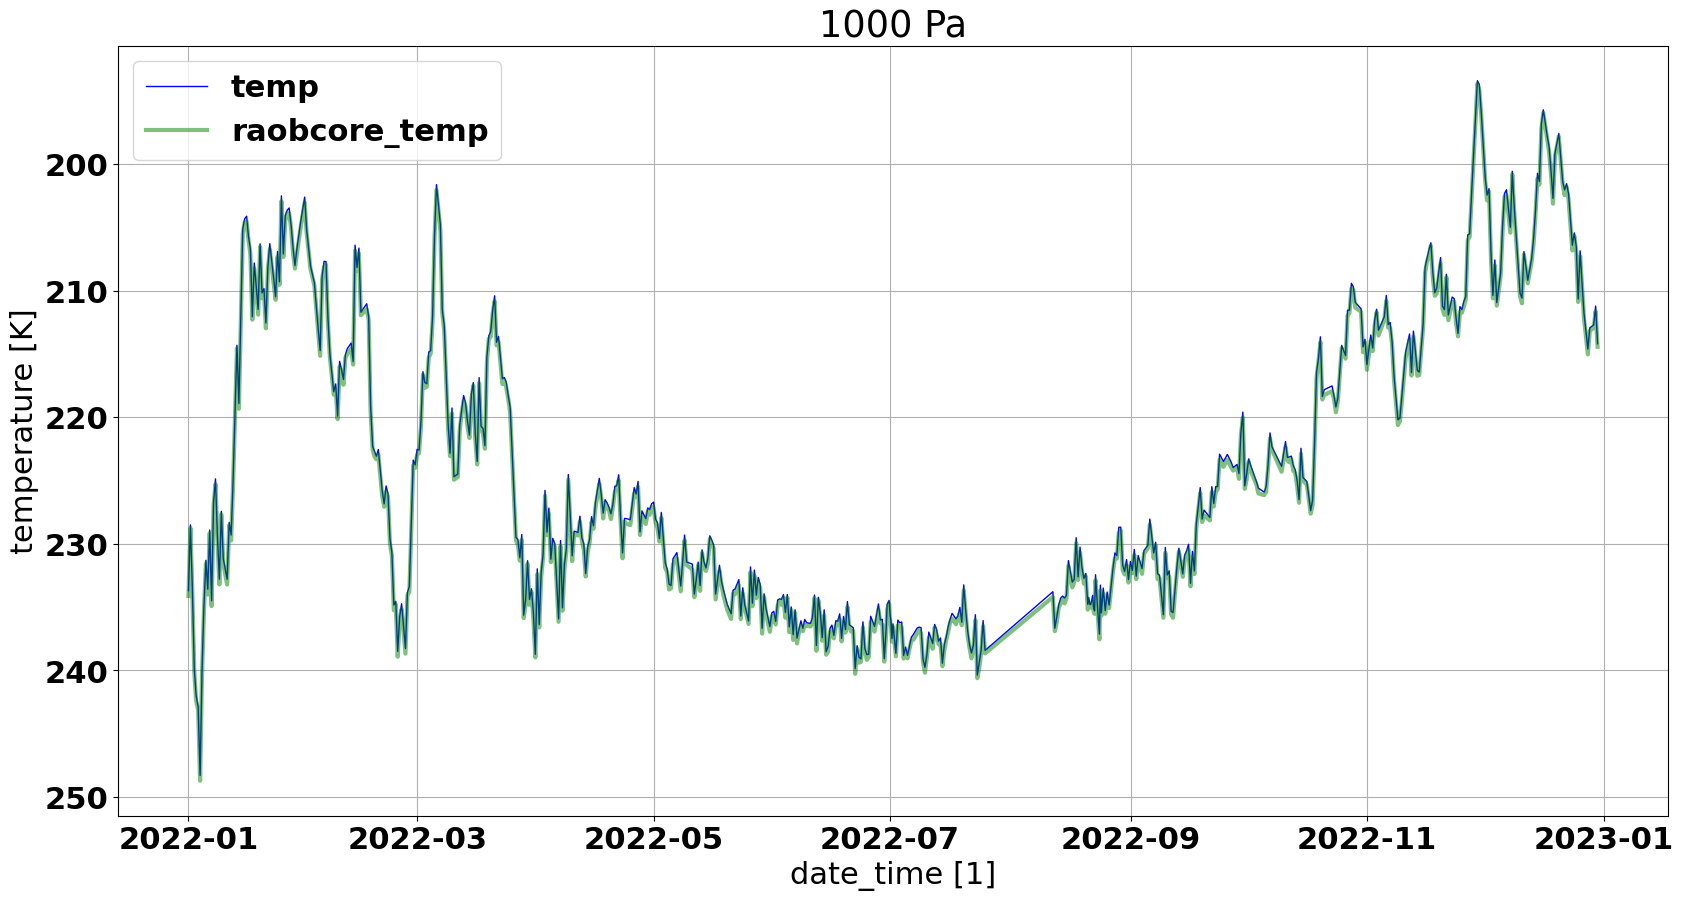

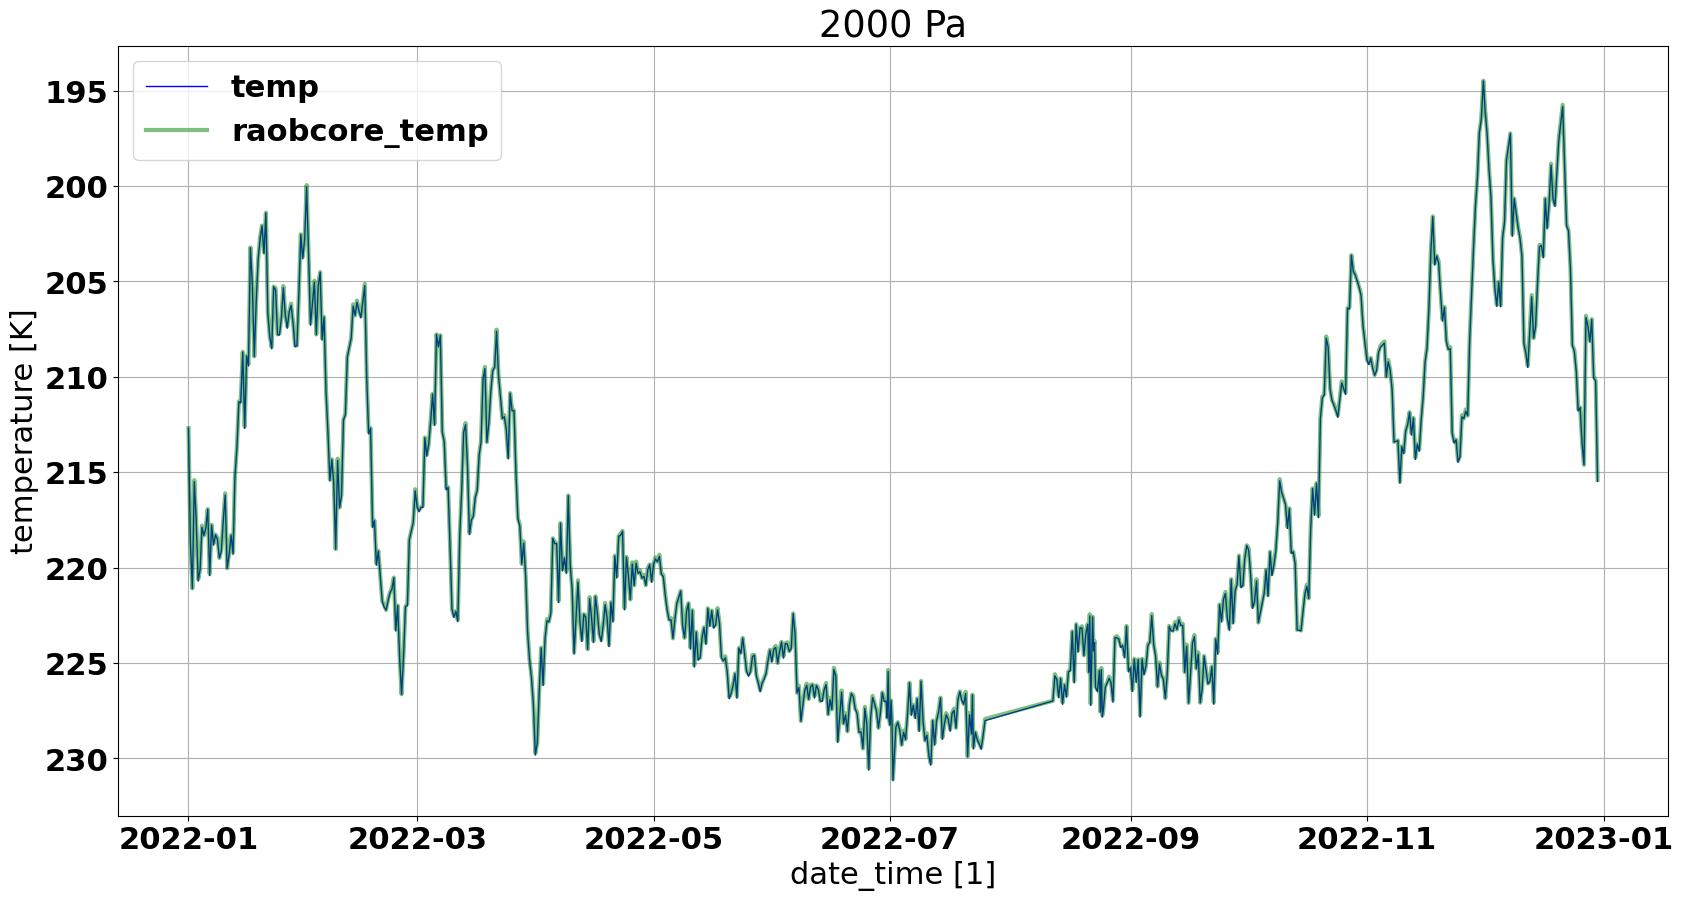

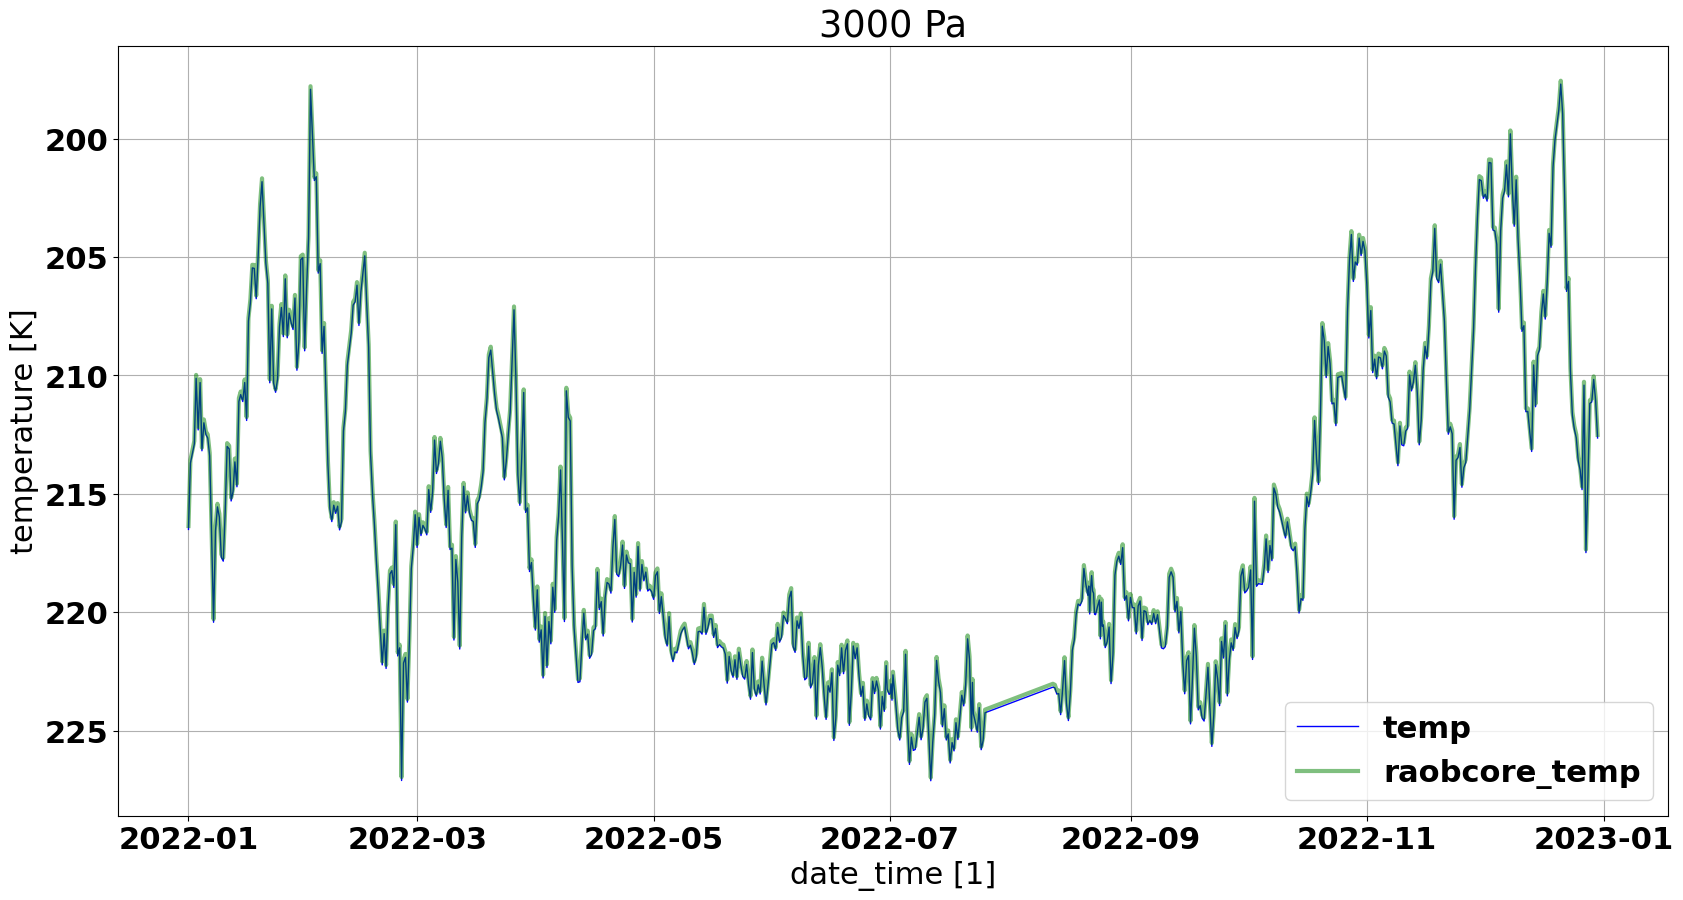

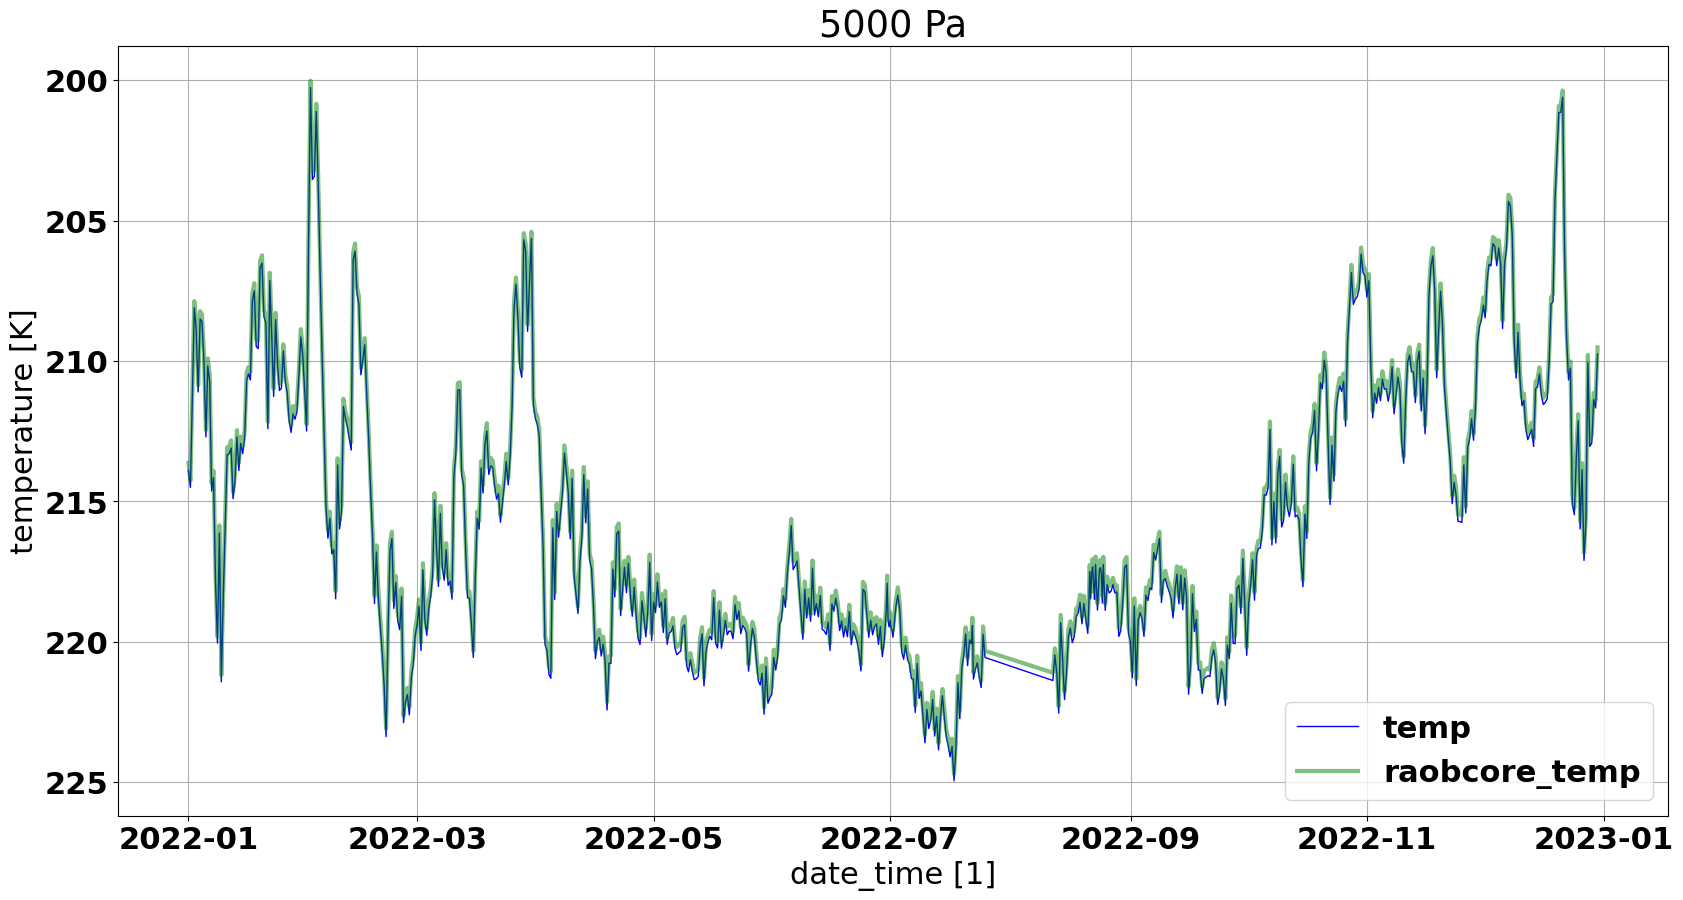

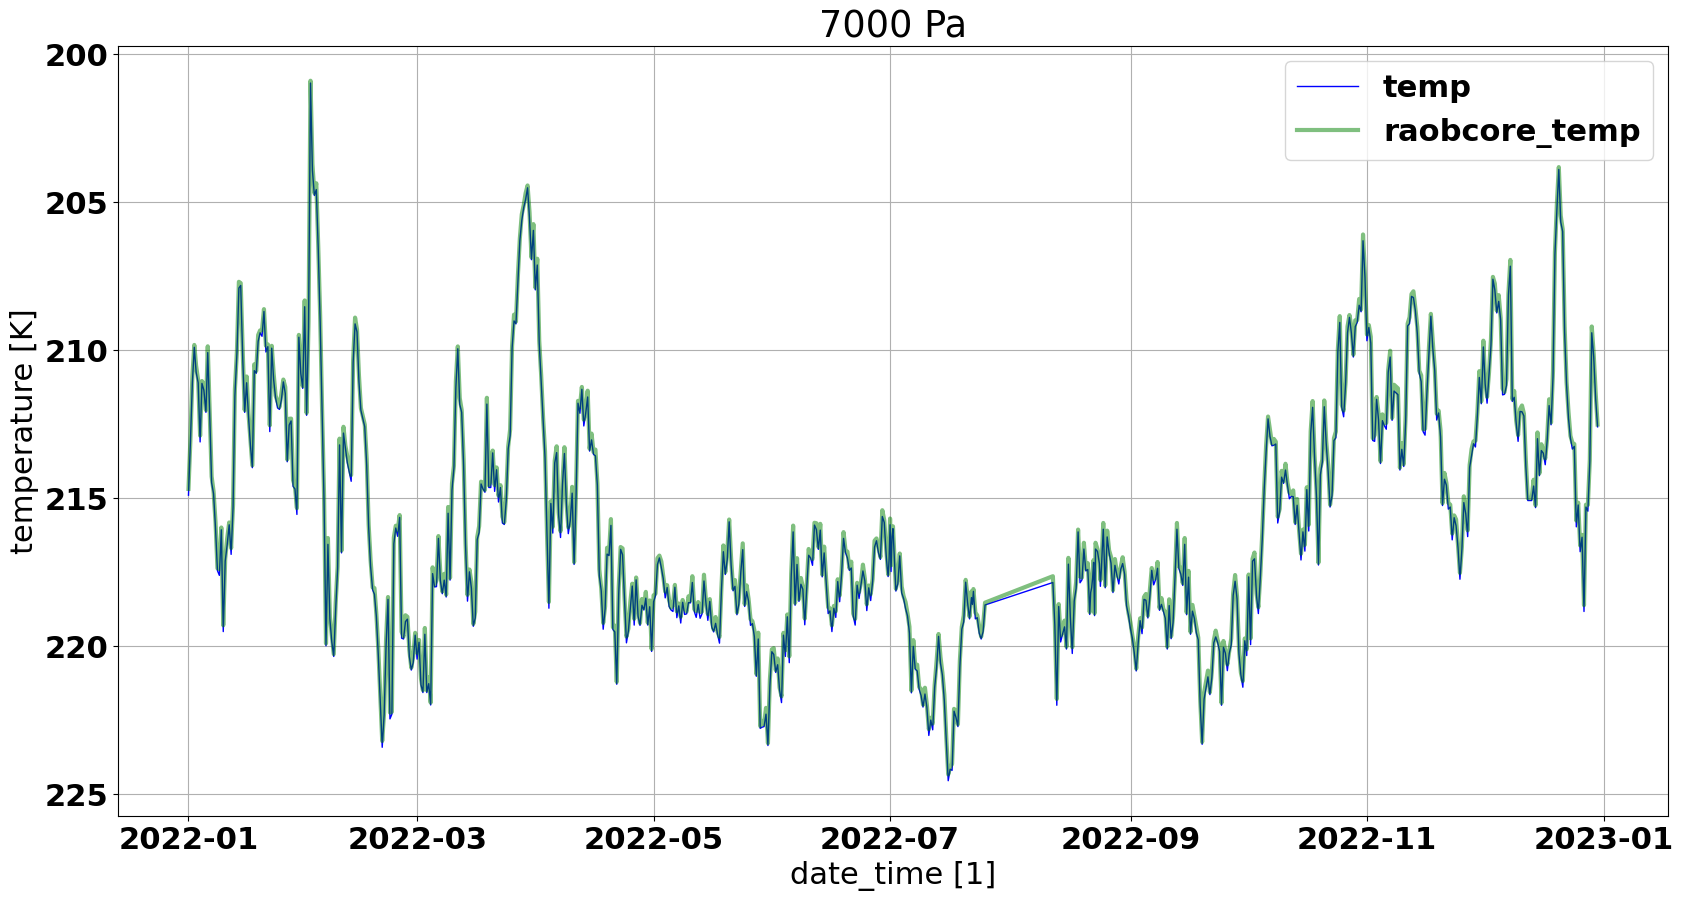

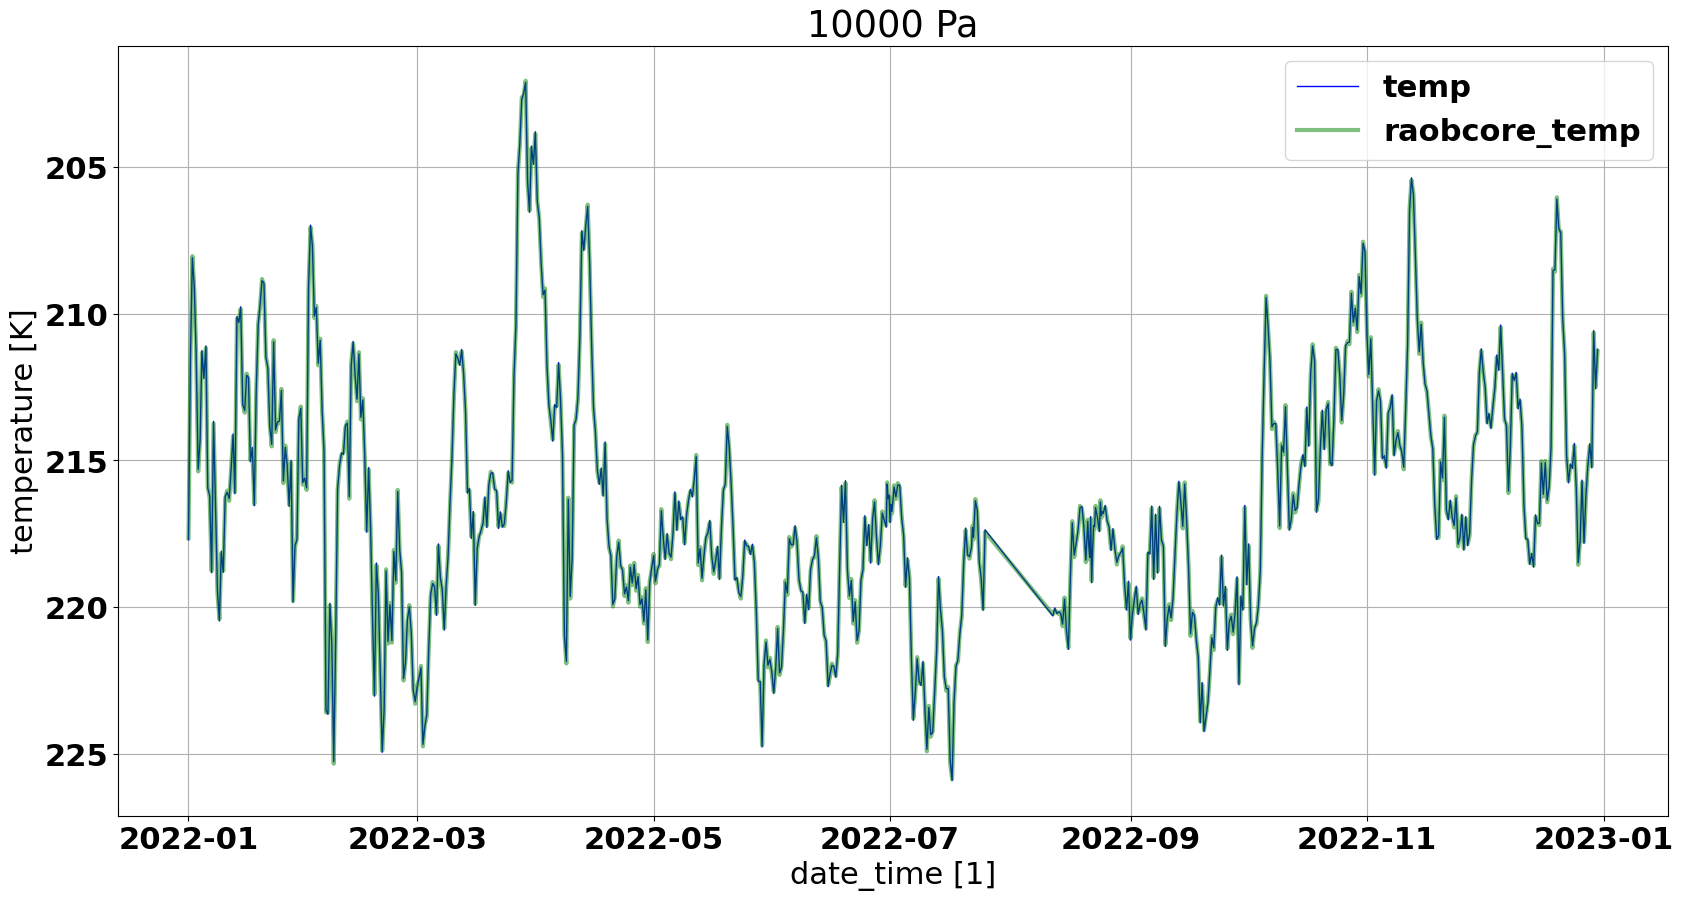

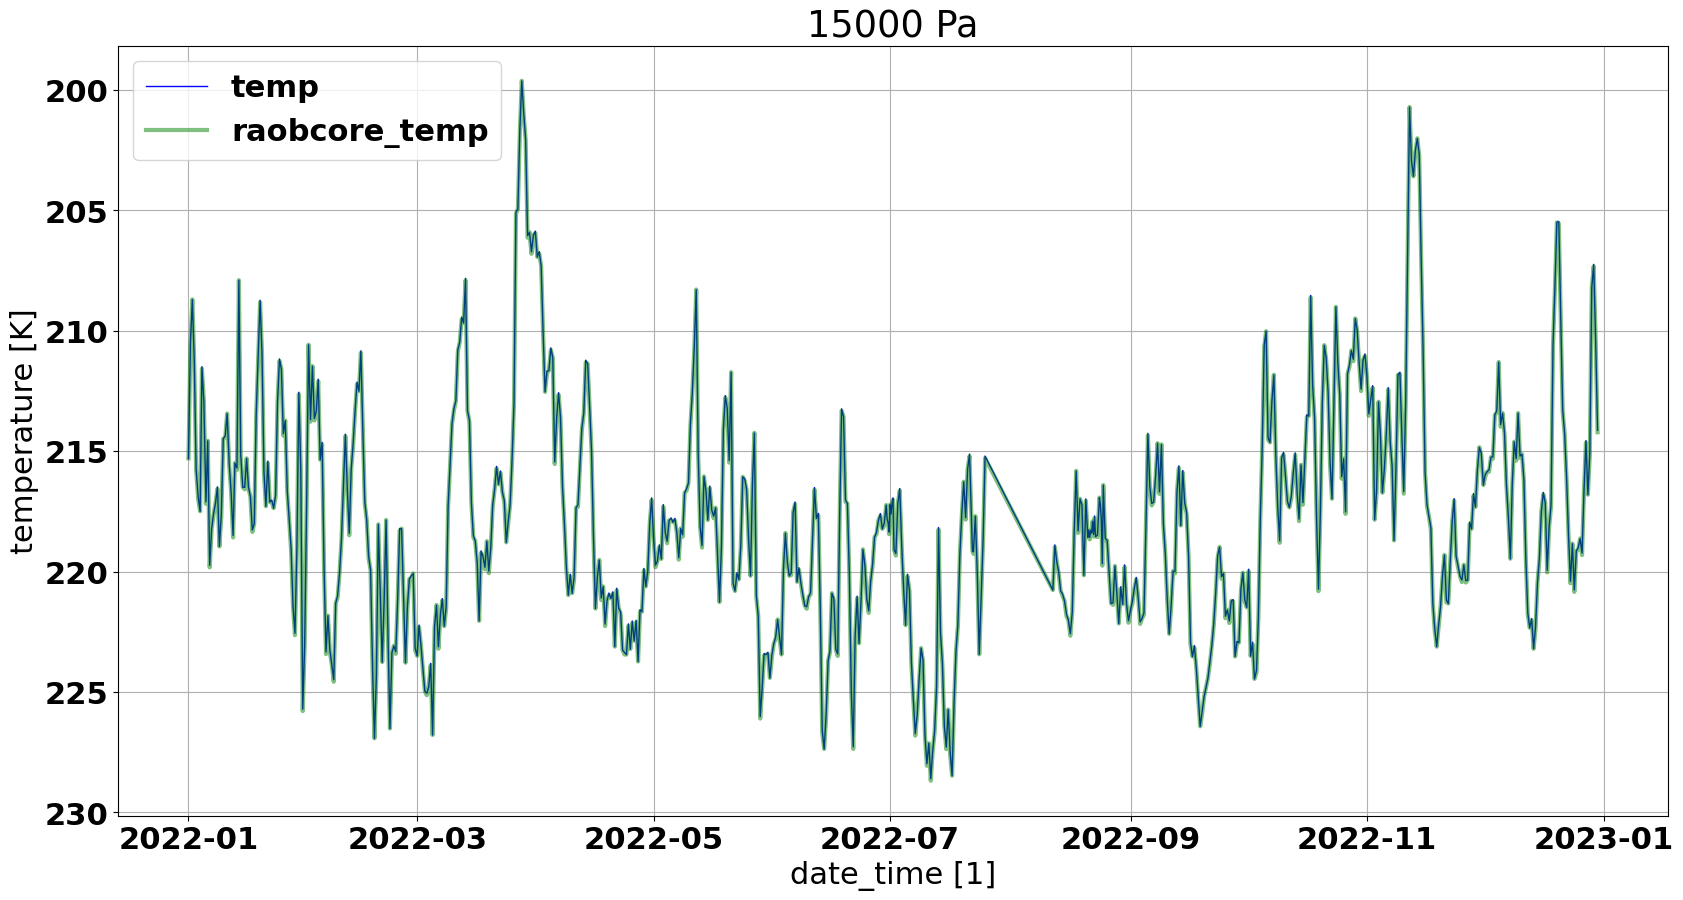

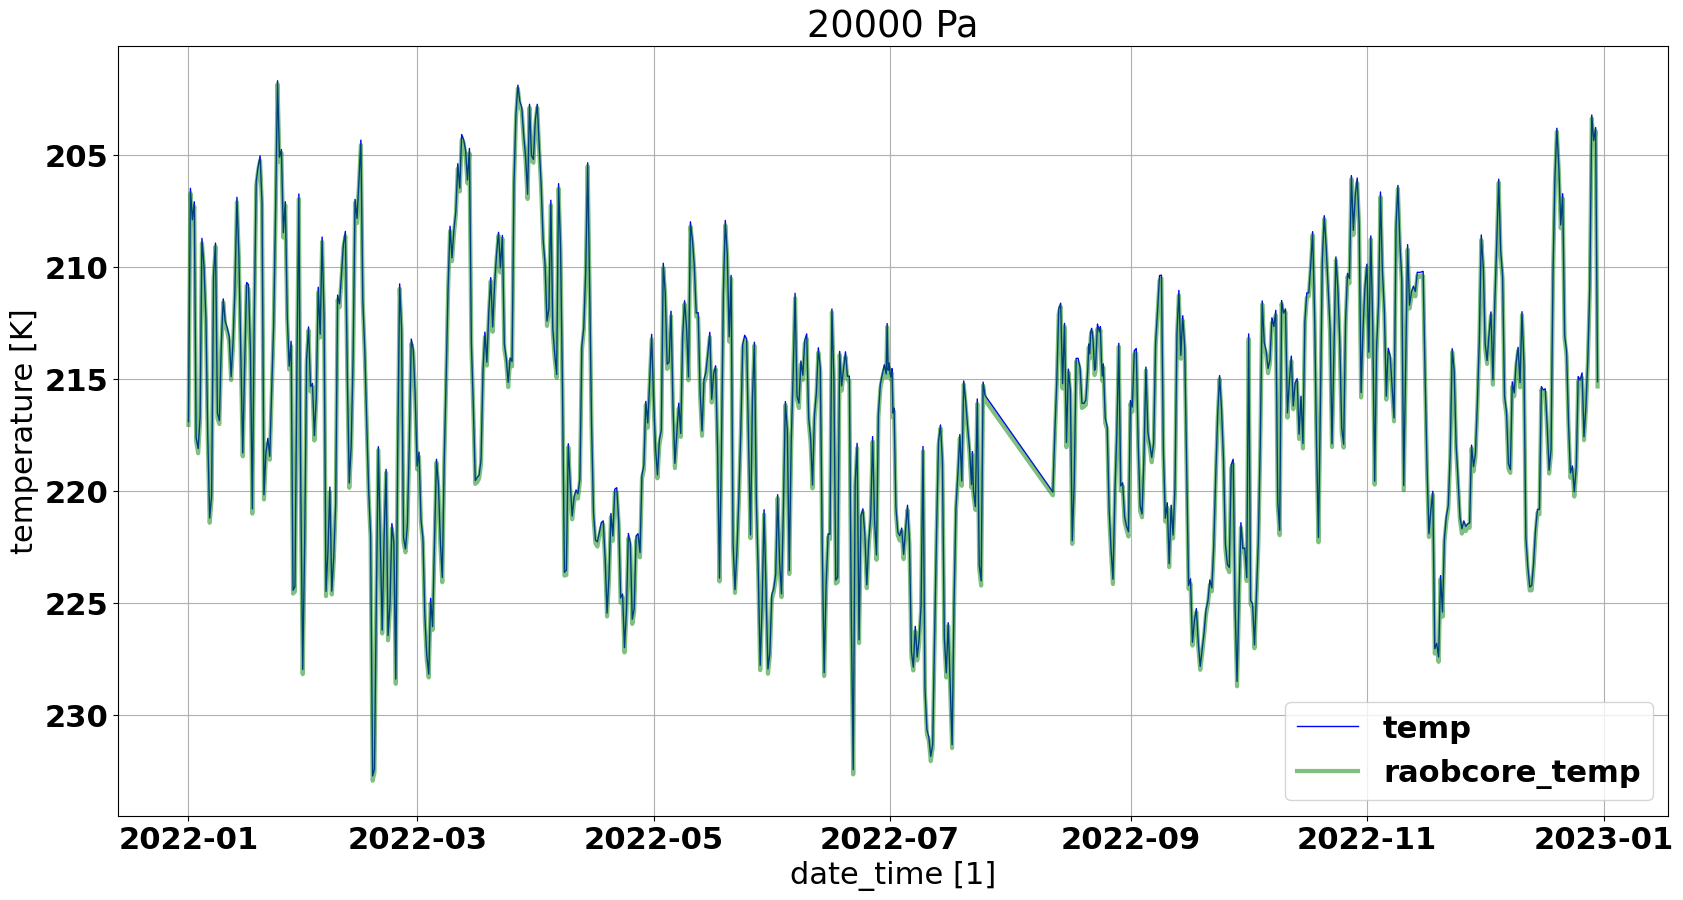

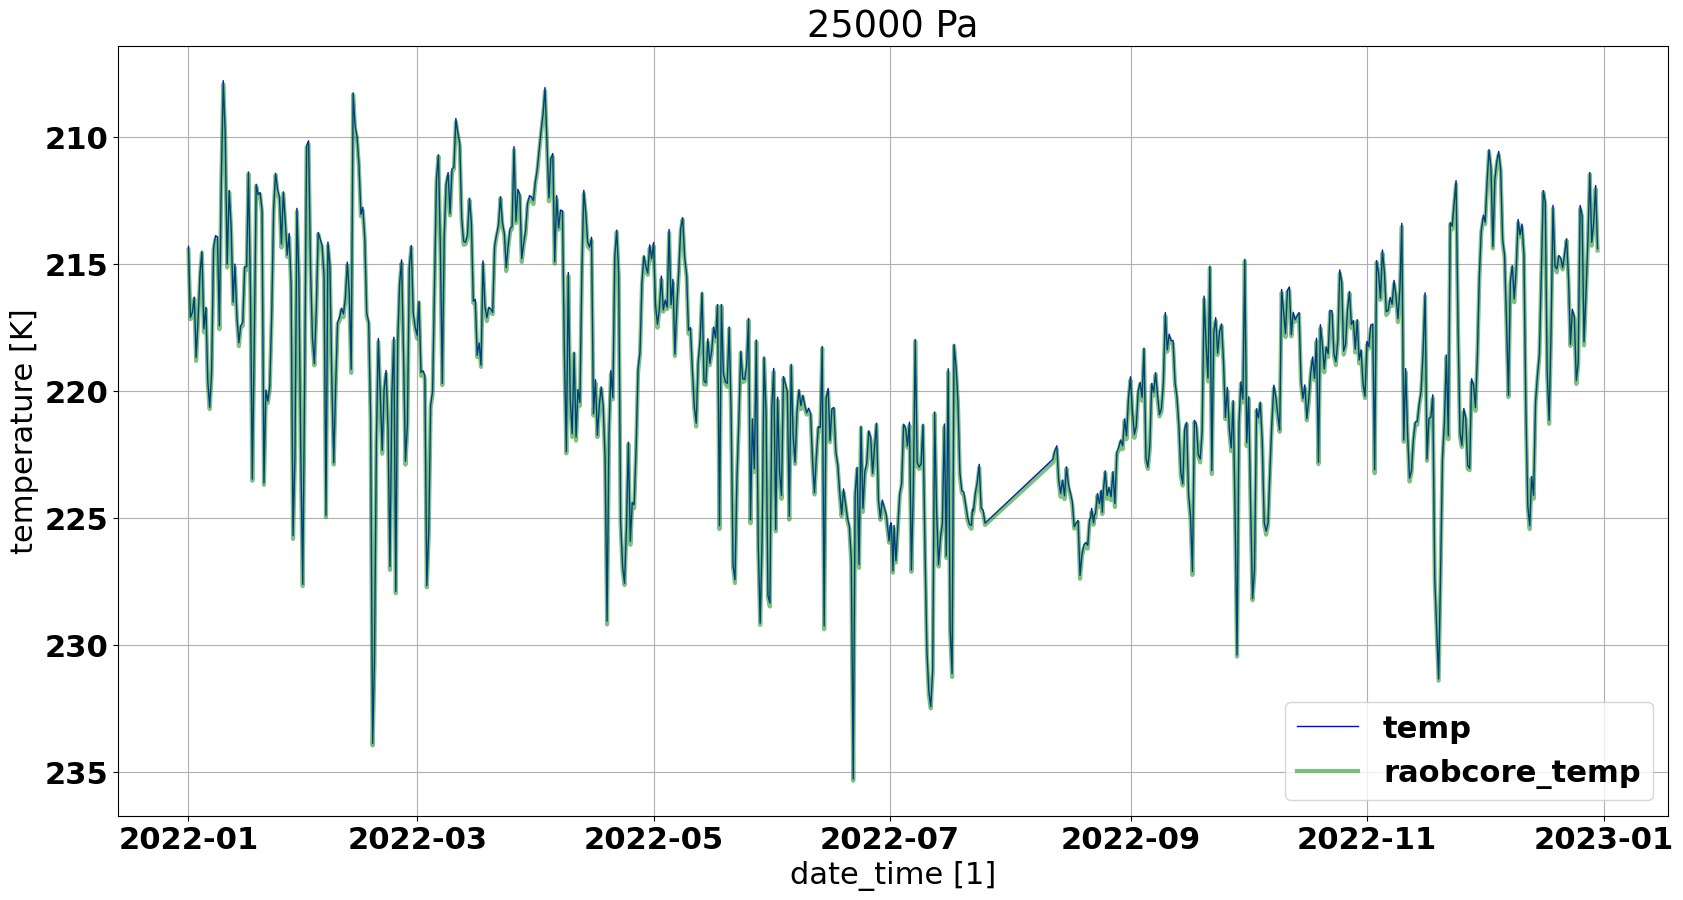

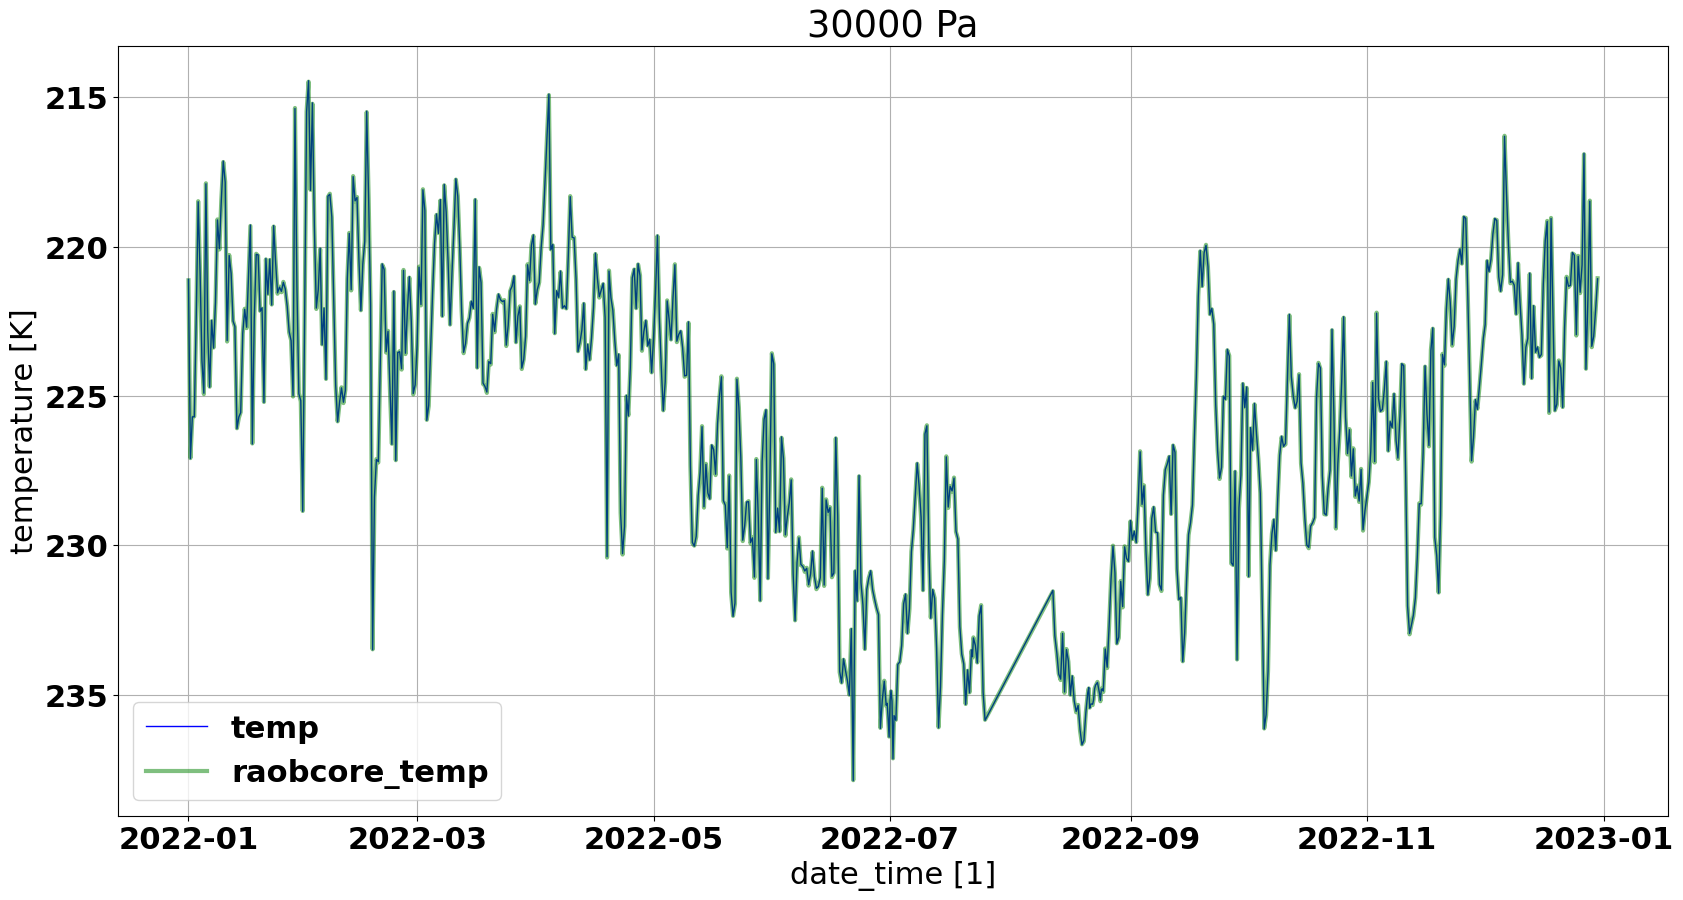

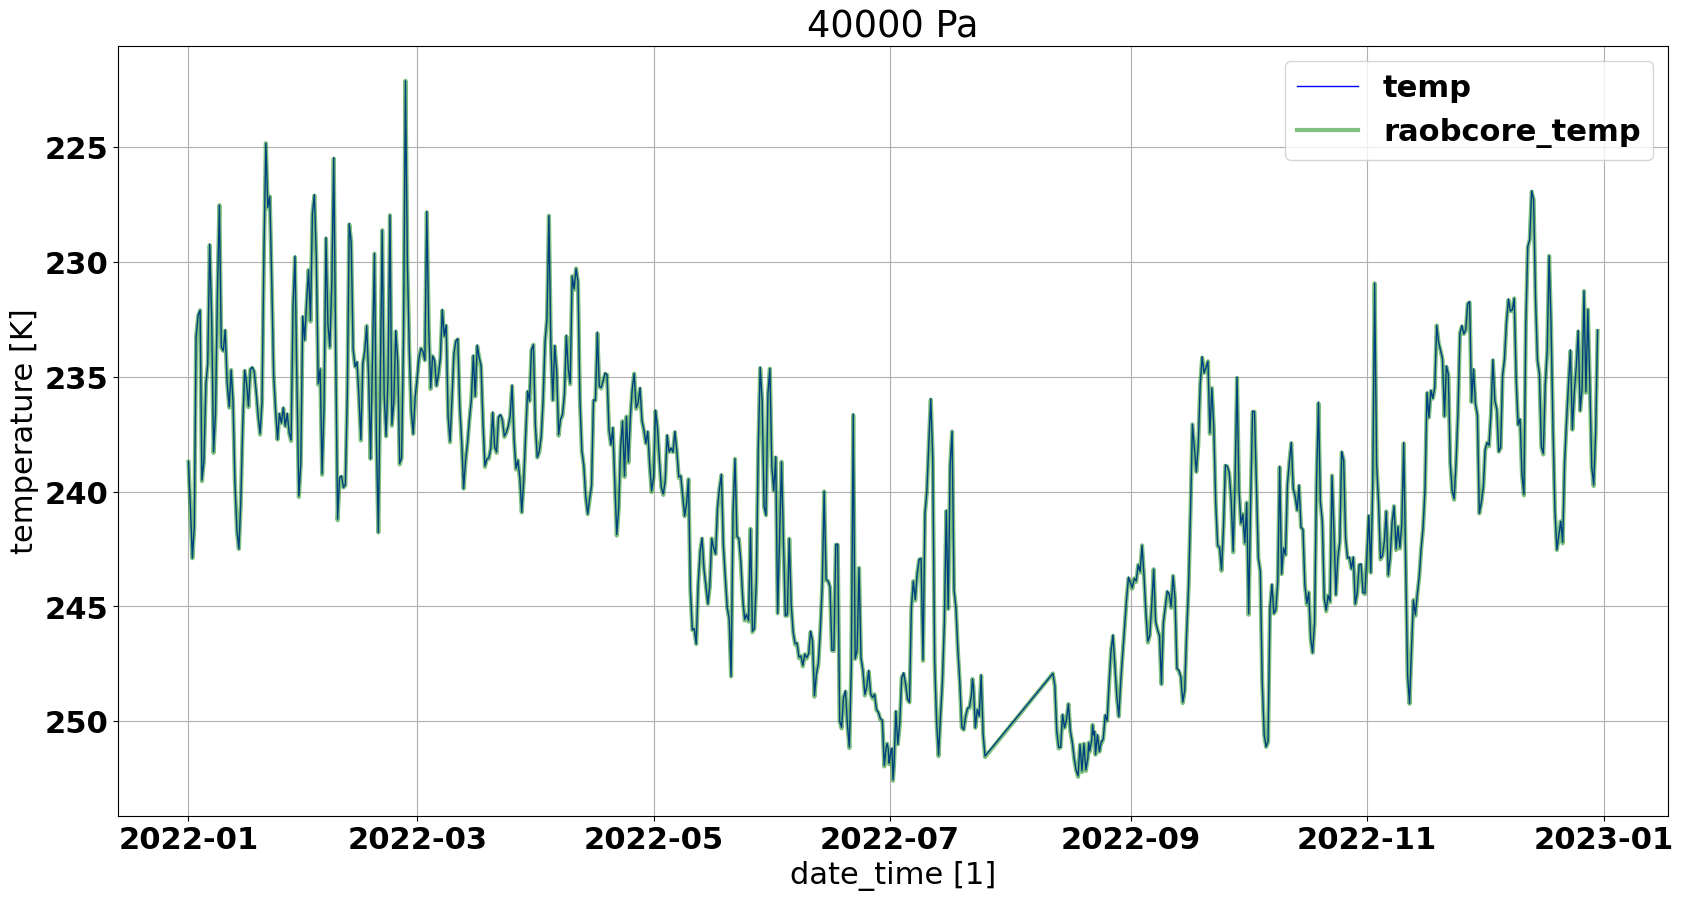

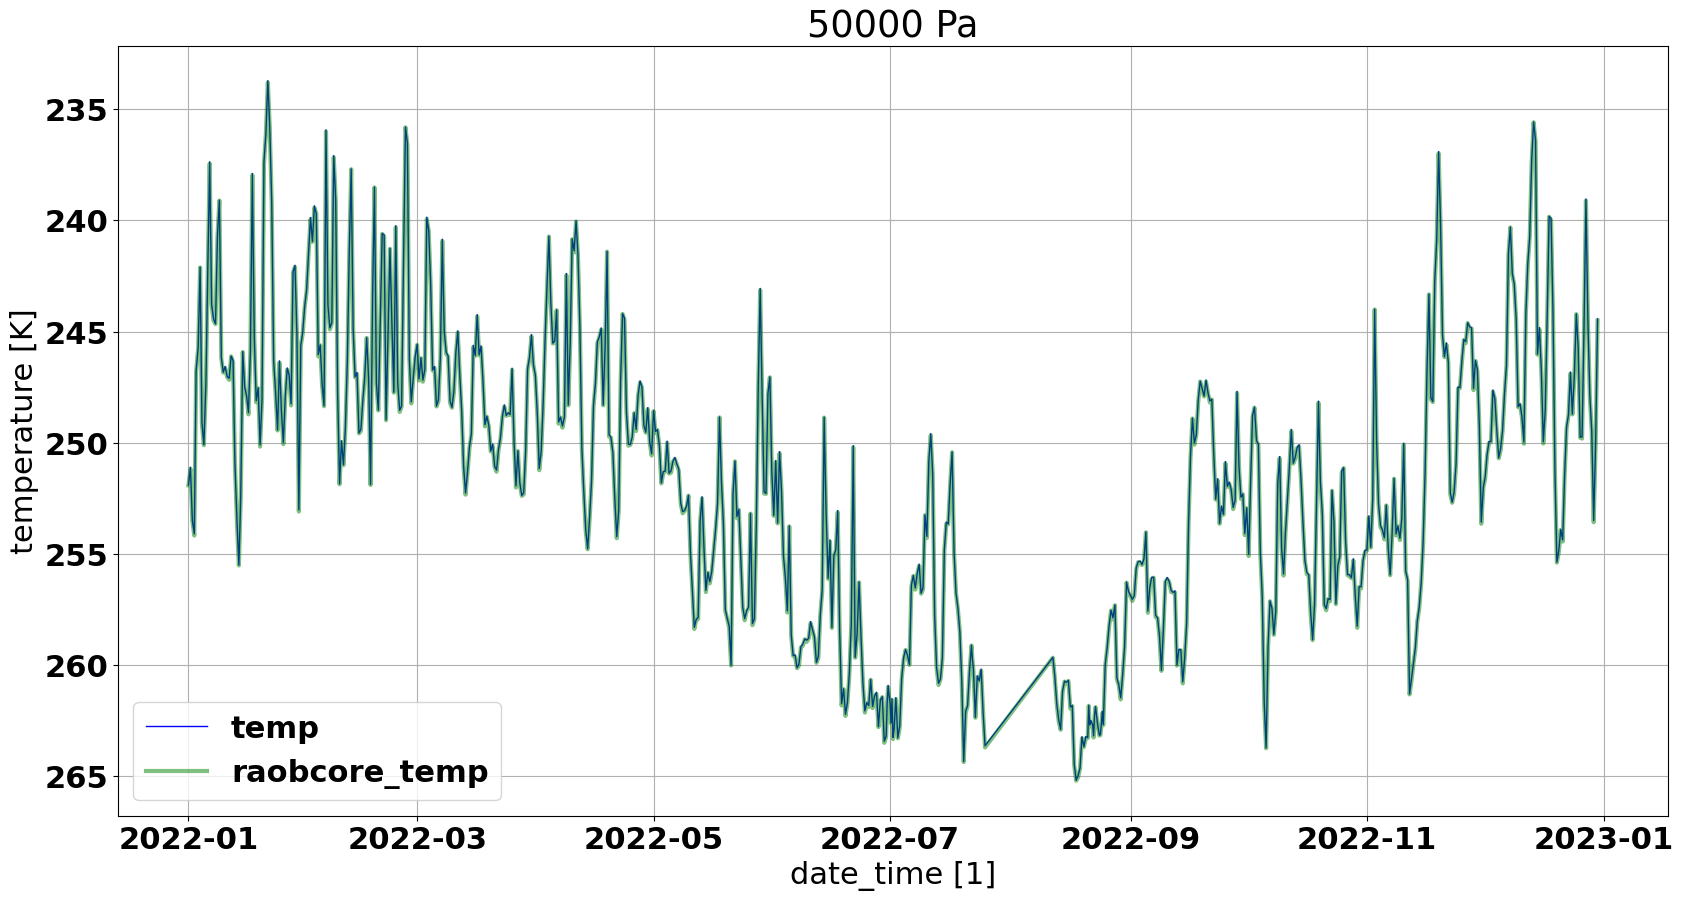

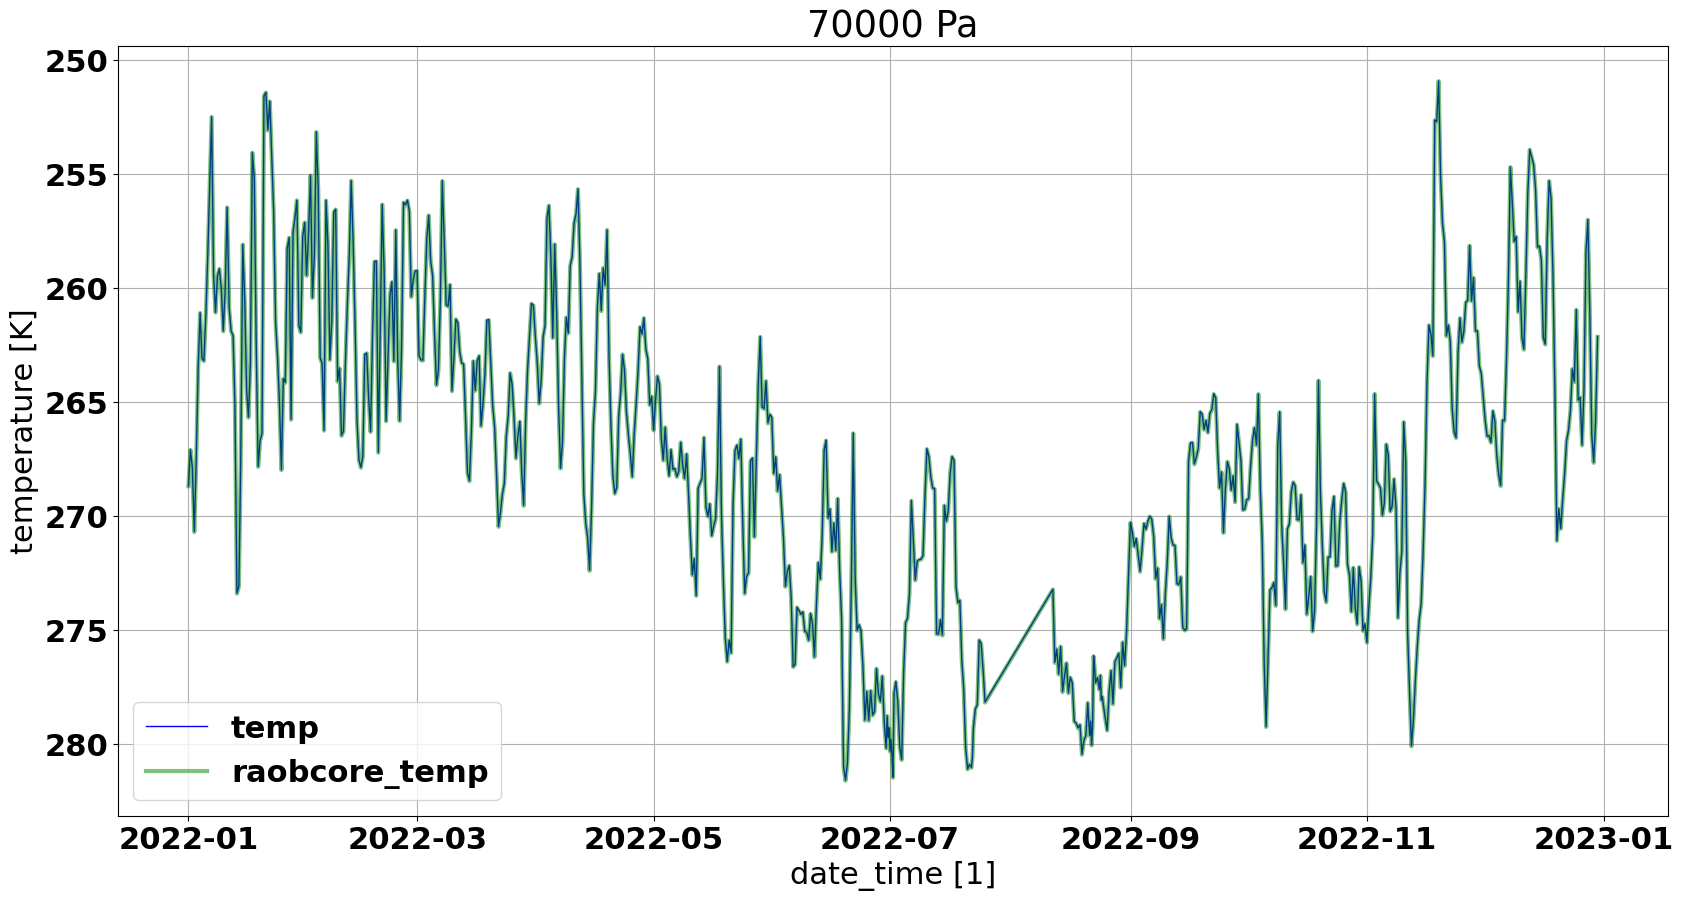

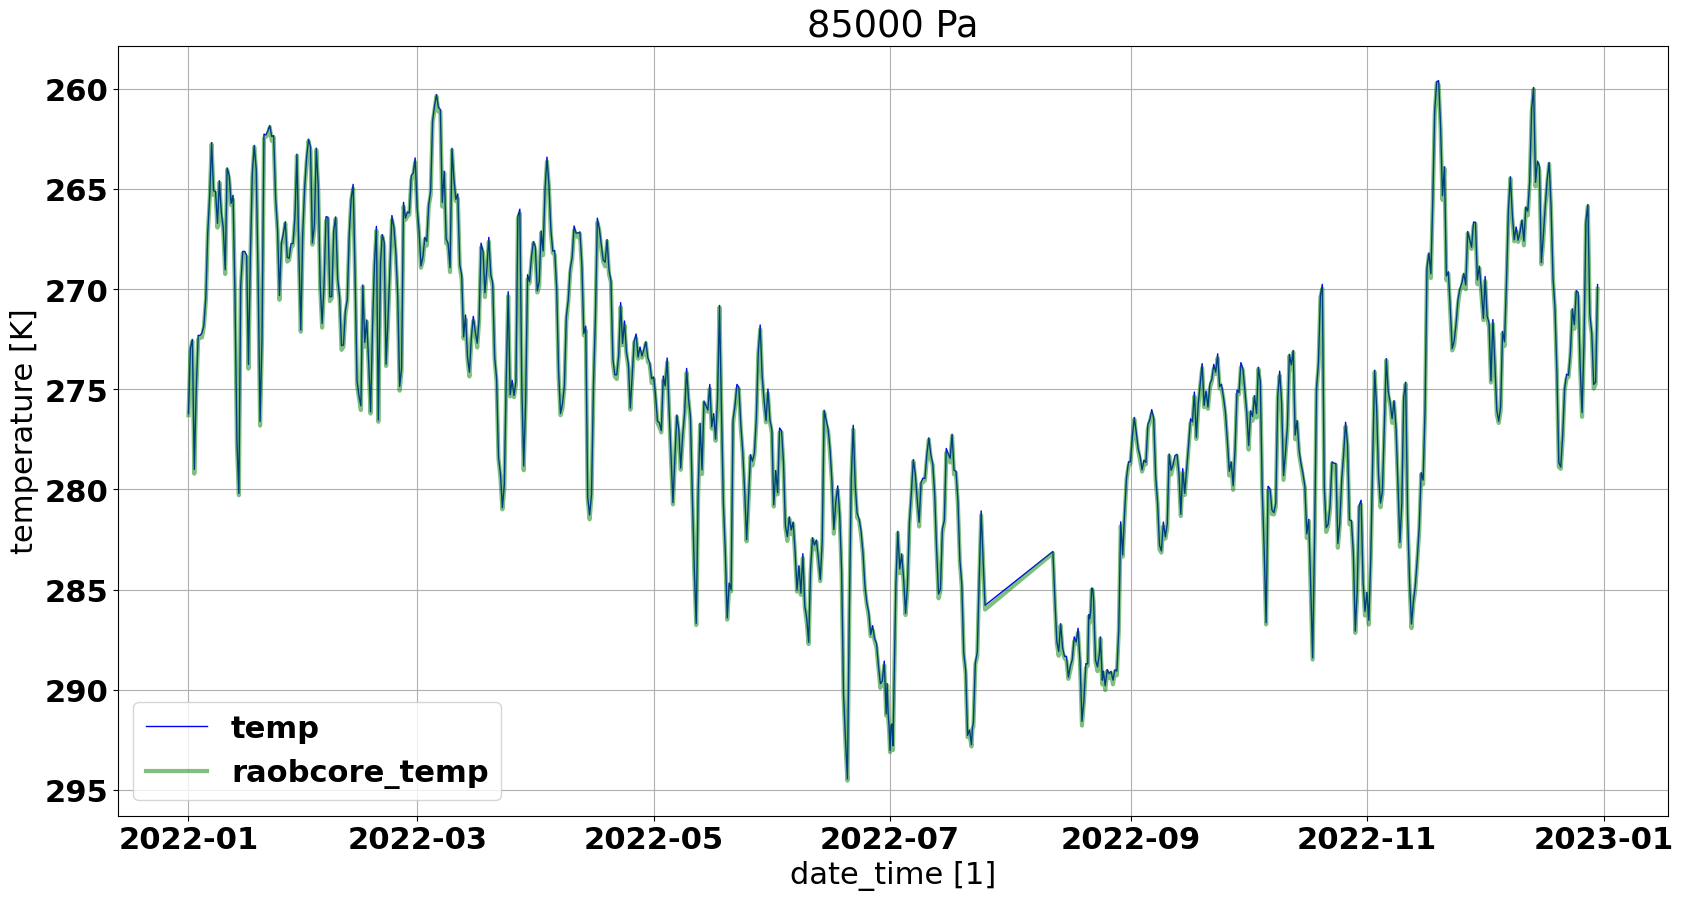

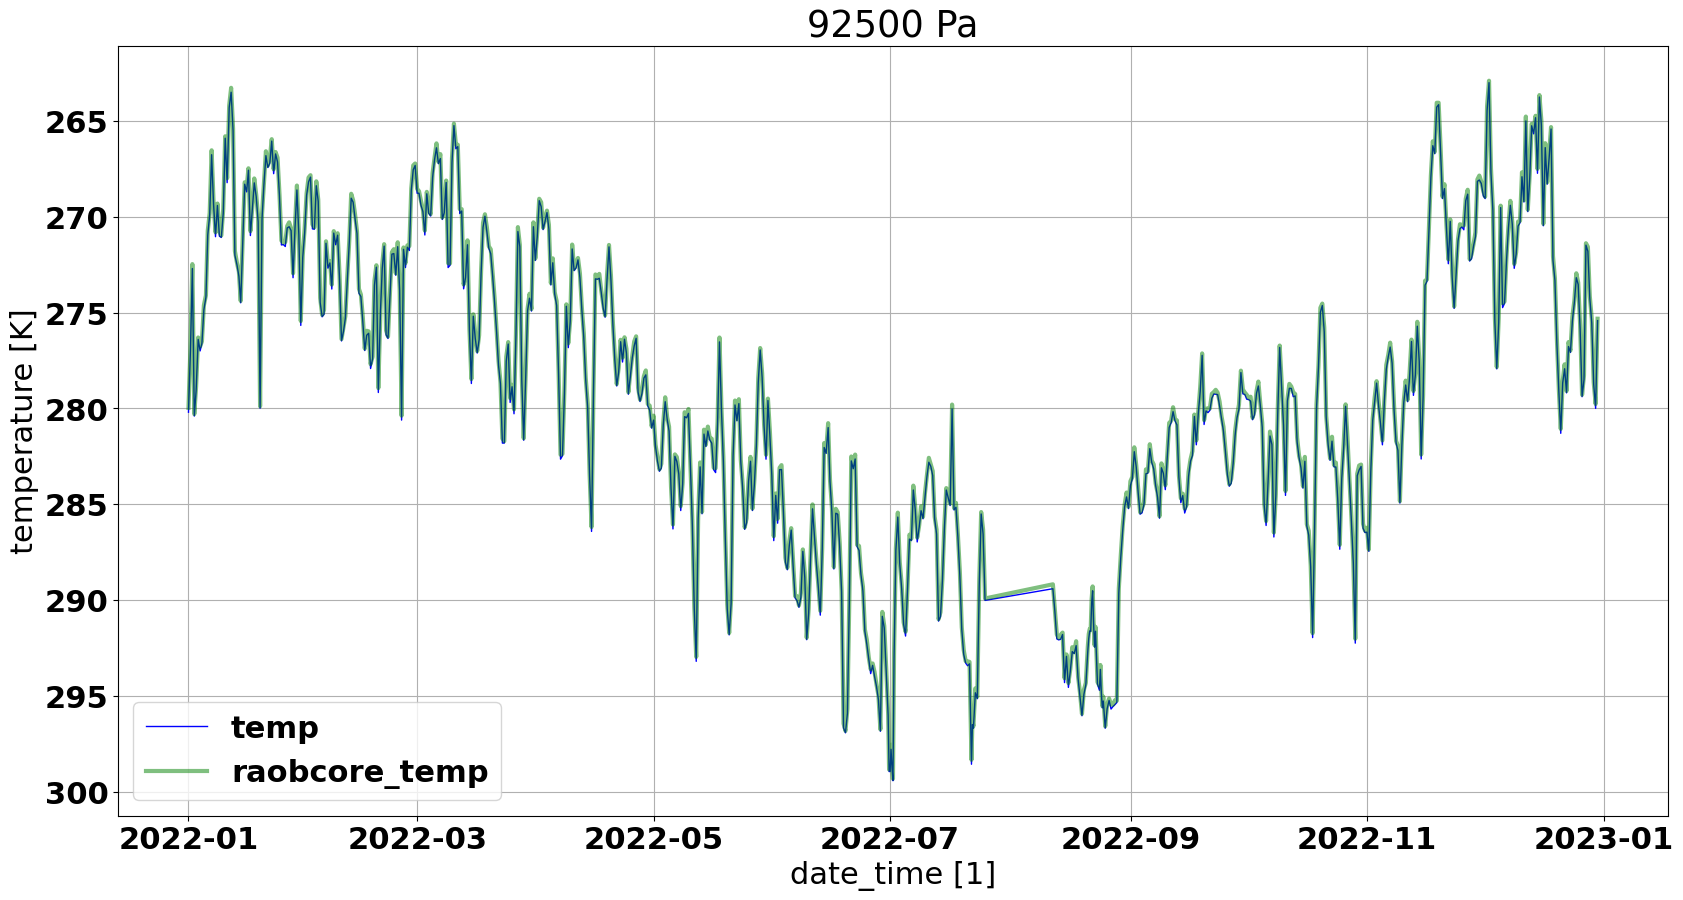

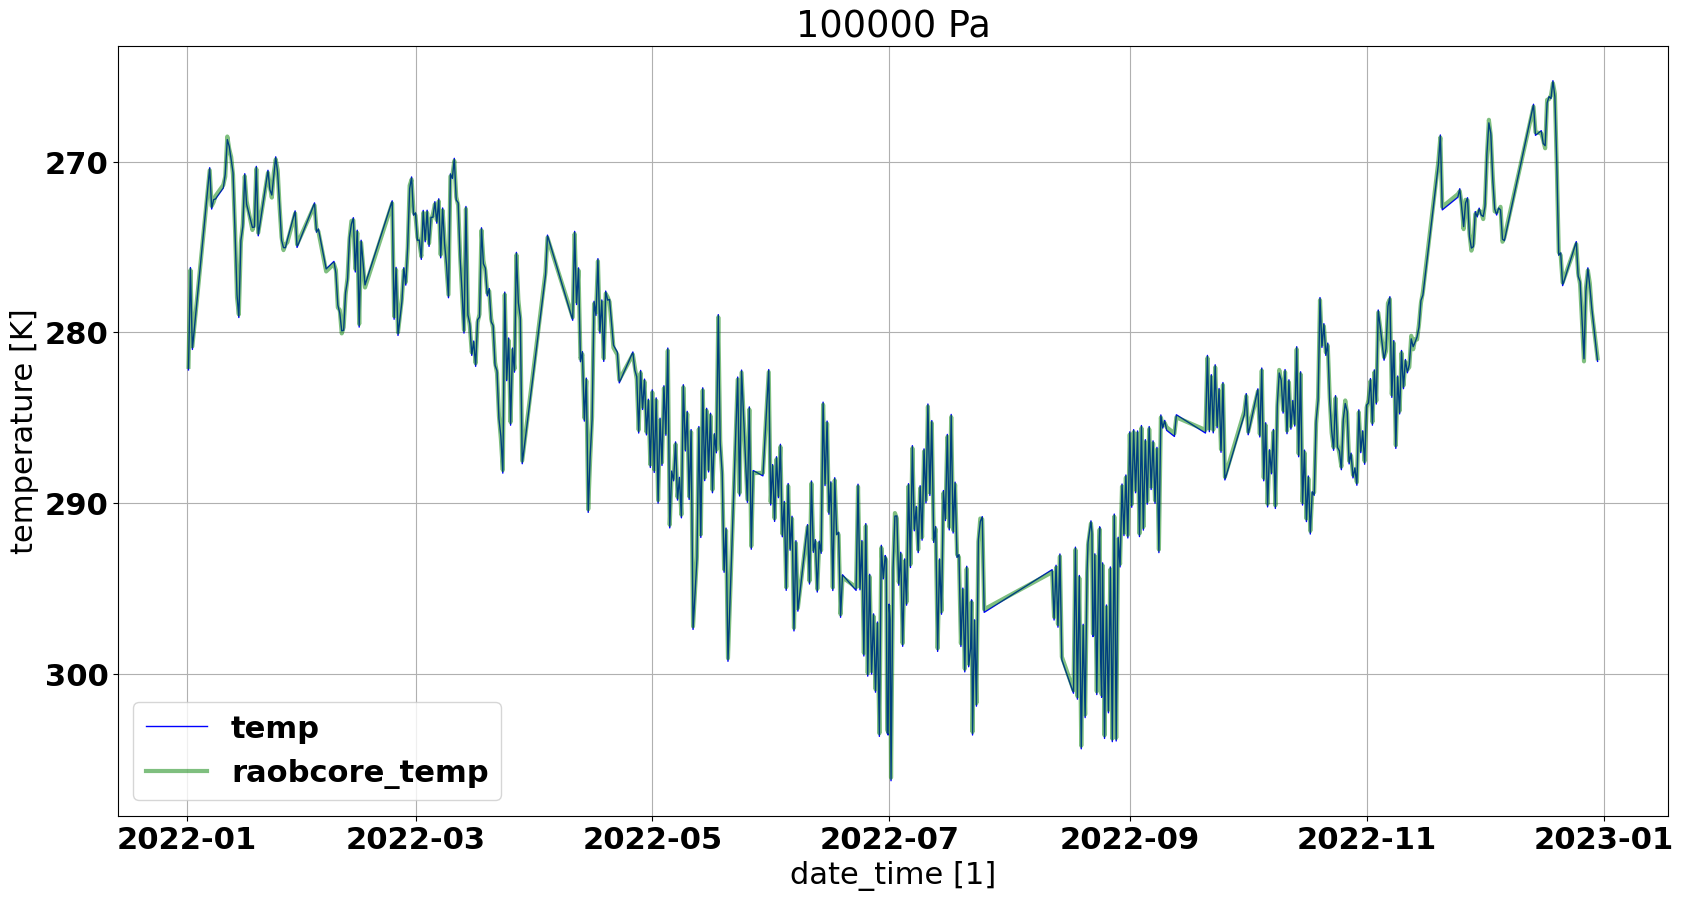

In [11]:
conv_file = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp00/*/*_CEUAS_merged_v1.nc')[1]
dt_from = datetime_to_seconds(np.datetime64('2022-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, 'r') as file:
    rts = file['recordindices']['recordtimestamp'][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
    idx_d = {}
    # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
    var_d = {'air_temperature':'126'}
    for i in var_d:
        idx_d[i] = file['recordindices'][var_d[i]][idx]

    masks = {}
    for i in idx_d:
        masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
        masks[i] = np.isin(masks[i],plevs)
        masks[i] = np.isfinite(masks[i])

    mask = masks['air_temperature']
    t_idx = idx_d['air_temperature']
    df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
    df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
    df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
df_old = pd.DataFrame.from_dict(df_dict)
for i in plevs:
    df_plev = df_old[df_old.z_coordinate == i]
    plt.plot(df_plev.date_time, df_plev.air_temperature, color = 'blue', linewidth = 1, alpha = 1, label='temp')
    plt.plot(df_plev.date_time, (df_plev.air_temperature - df_plev.RAOBCORE_bias_estimate), color = 'green', linewidth = 3, alpha = 0.5, label='raobcore_temp')

    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])

    plt.title(str(i) + ' Pa')
    plt.ylabel('temperature [K]')
    plt.xlabel('date_time [1]')
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

In [16]:
plev = 10000
lat_list = []
lon_list = []
lable_list = []
value_list = []
value_adjusted_list = []
mean_noon_adjustment_list = []
mean_midnight_adjustment_list = []


dt_from = datetime_to_seconds(np.datetime64('2022-01-01'))
dt_to = datetime_to_seconds(np.datetime64('2022-12-31'))

for stat in glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*_CEUAS_merged_v1.nc')[0:200]:
    try:
        df_dict = {}
        print(stat)
        with h5py.File(stat, 'r') as file:
            rts = file['recordindices']['recordtimestamp'][:]
            idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
            plevs = [plev]
            idx_d = {}
            # var_d = {'air_temperature':'126', 'relative_humidity':'138', 'geopotential':'117', 'eastward_wind_speed':'139', 'northward_wind_speed':'140', 'dew_point': '137', 'specific_humidity':'39'}
            var_d = {'air_temperature':'126'}
            for i in var_d:
                idx_d[i] = file['recordindices'][var_d[i]][idx]

            masks = {}
            for i in idx_d:
                masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
                masks[i] = np.isin(masks[i],plevs)
                masks[i] = np.isfinite(masks[i])

            mask = masks['air_temperature']
            t_idx = idx_d['air_temperature']
            df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['date_time'] = seconds_to_datetime(list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask]))
            df_dict['RAOBCORE_bias_estimate'] = list(file['advanced_homogenisation']['RAOBCORE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
            df_dict['air_temperature'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
            lat_list.append(file['observations_table']['latitude'][-1])
            lon_list.append(file['observations_table']['longitude'][-1])

        lable_list.append(stat.split('/')[-2])
        df = pd.DataFrame.from_dict(df_dict)
        df = df[np.isin(df.z_coordinate, plevs)]
        df.date_time = pd.to_datetime(df.date_time)
        day_night_diff = []
        day_night_diff_adjusted = []
        noon_adjustments = []
        midnight_adjustments = []
        for j in df.date_time.drop_duplicates():
            day_df = df[df.date_time.dt.date == j.date()]
            noon_df = day_df[np.isin(day_df.date_time.dt.hour, [11,12,13])]
            midnight_df = day_df[np.isin(day_df.date_time.dt.hour, [23,0,1])]
            if np.logical_and(len(midnight_df) > 0, len(noon_df) > 0):
                day_night_diff.append(noon_df.air_temperature.iloc[0] - midnight_df.air_temperature.iloc[0])
                day_night_diff_adjusted.append((noon_df.air_temperature.iloc[0]-noon_df.RAOBCORE_bias_estimate.iloc[0]) - (midnight_df.air_temperature.iloc[0]-midnight_df.RAOBCORE_bias_estimate.iloc[0]))
                noon_adjustments.append(float(noon_df.RAOBCORE_bias_estimate.iloc[0]))
                midnight_adjustments.append(float(midnight_df.RAOBCORE_bias_estimate.iloc[0]))
        value_list.append(np.nanmean(day_night_diff))
        value_adjusted_list.append(np.nanmean(day_night_diff_adjusted))
        mean_noon_adjustment_list.append(np.nanmean(noon_adjustments))
        mean_midnight_adjustment_list.append(np.nanmean(midnight_adjustments))
    except:
        pass
    
# points(lon_list, lat_list, lable_list, value_list)
# points(lon_list, lat_list, lable_list, value_adjusted_list)

/users/staff/leo/fastscratch/rise/1.0/exp00/016597/0-20000-0-16597_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/012374/0-20000-0-12374_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/017095/0-20000-0-17095_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/017030/0-20000-0-17030_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/017064/0-20000-0-17064_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/060580/0-12-20000-60580_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/001025/0-20000-0-01025_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/002229/0-20000-0-02229_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/032006/0-152-0-320063_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/002974/0-20000-0-02974_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/073033/0-124-0-73033_CEUAS_merged_v1.nc
/users/staff/leo/fastscratch/rise/1.0/exp00/002226/0-200

<GeoAxesSubplot:title={'center':' unadjusted_day_night_diff_100hPa'}>

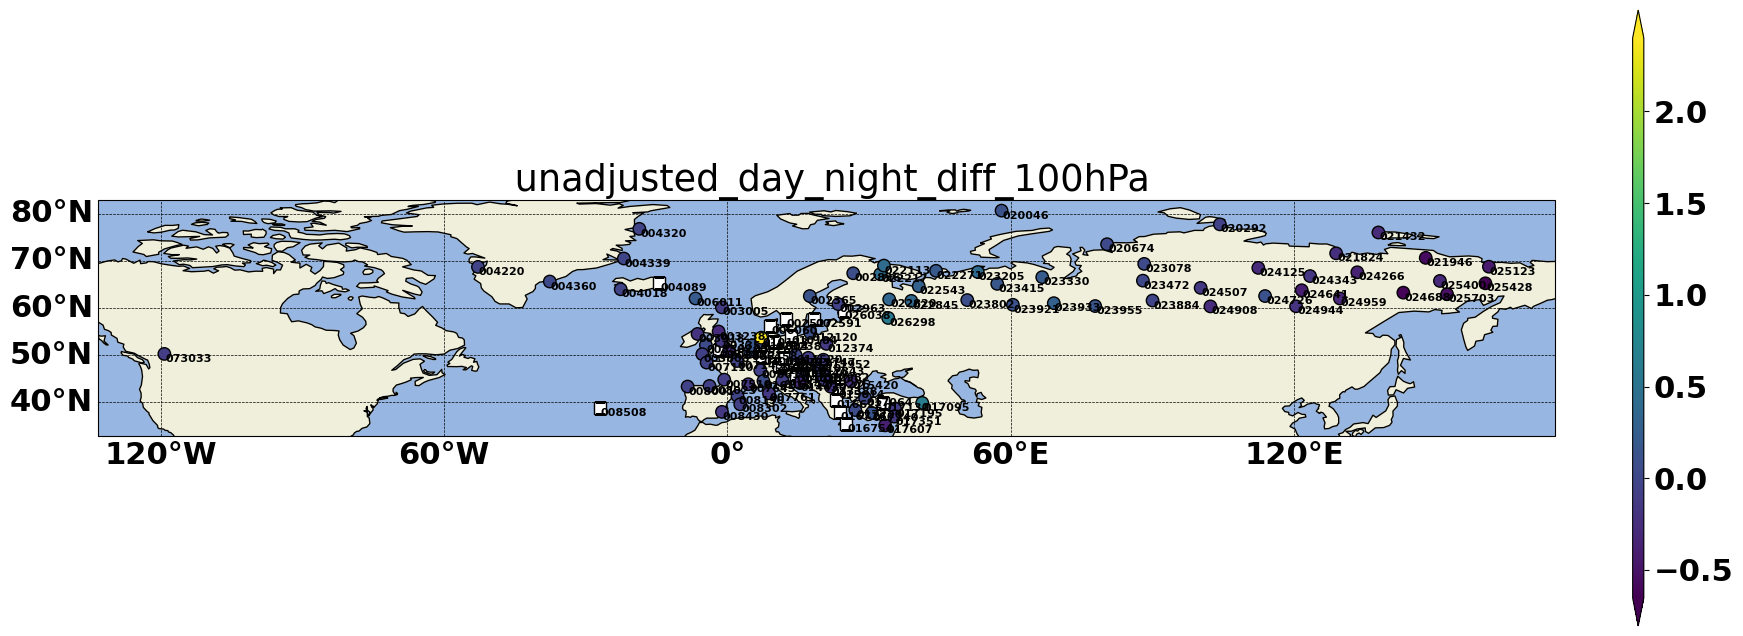

In [17]:
matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
matplotlib.rc('font', **font)

points(lon_list, lat_list, lable_list, value_list, showtitle='unadjusted_day_night_diff_100hPa')

<GeoAxesSubplot:title={'center':' adjusted_day_night_diff_100hPa'}>

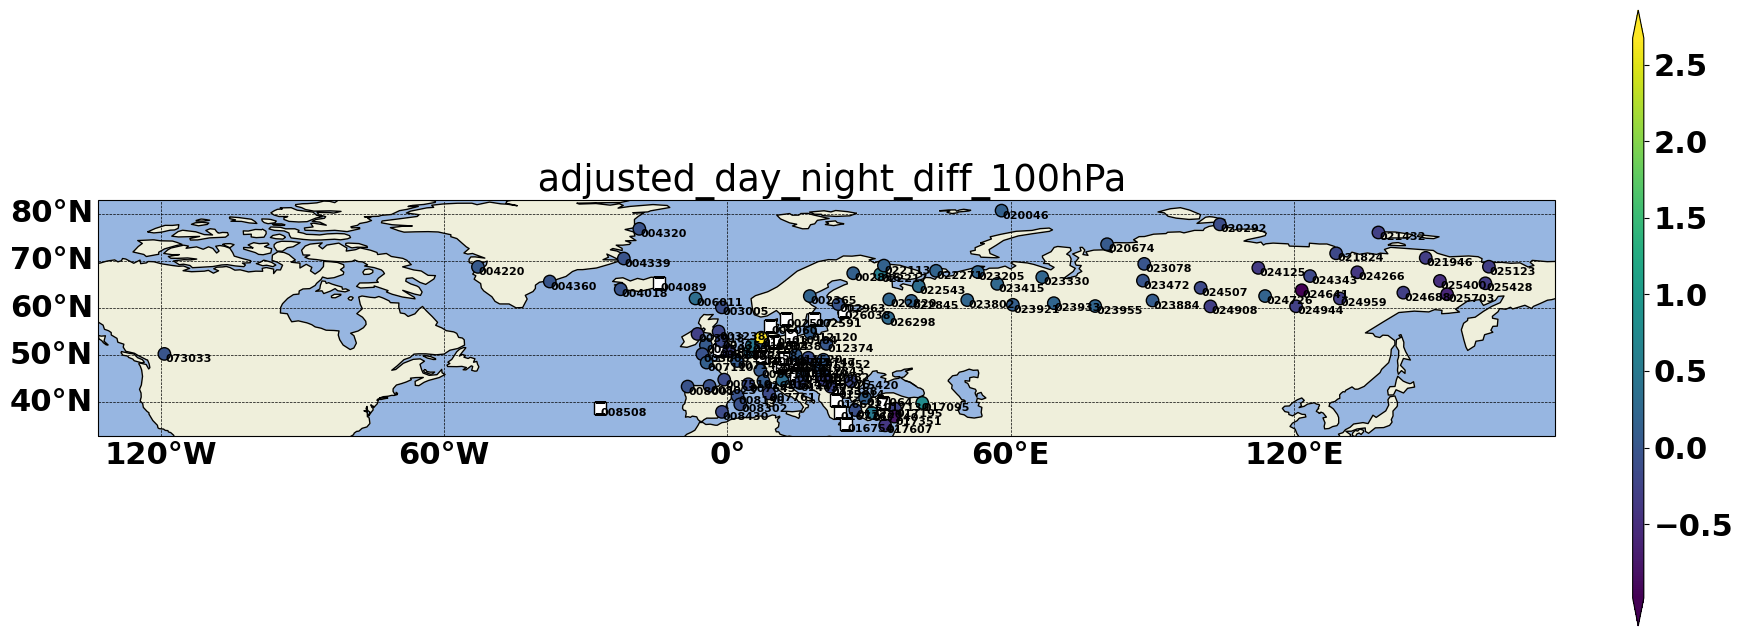

In [18]:
points(lon_list, lat_list, lable_list, value_adjusted_list, showtitle='adjusted_day_night_diff_100hPa')

<GeoAxesSubplot:title={'center':' mean_noon_adjustment_100hPa'}>

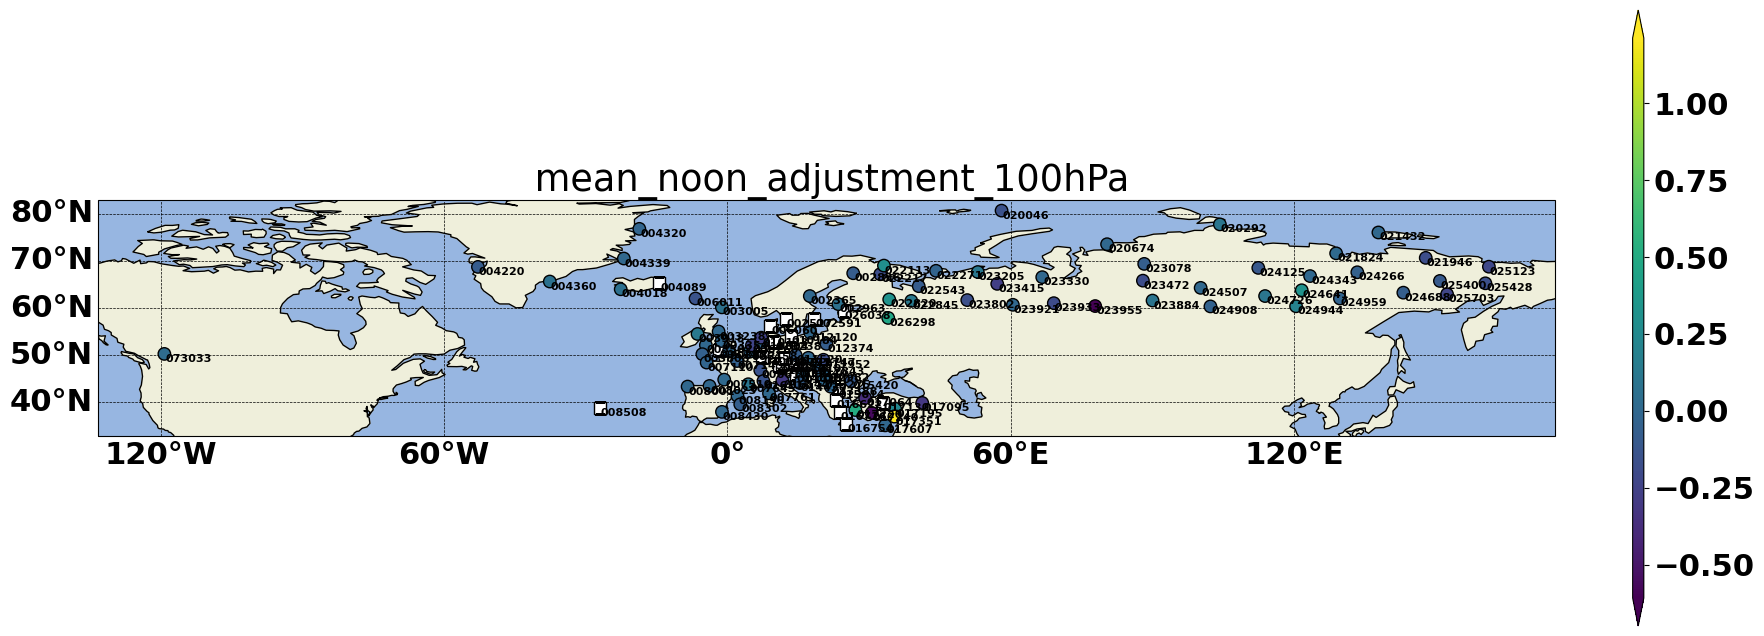

In [19]:
points(lon_list, lat_list, lable_list, mean_noon_adjustment_list, showtitle='mean_noon_adjustment_100hPa')

<GeoAxesSubplot:title={'center':' mean_midnight_adjustment_100hPa'}>

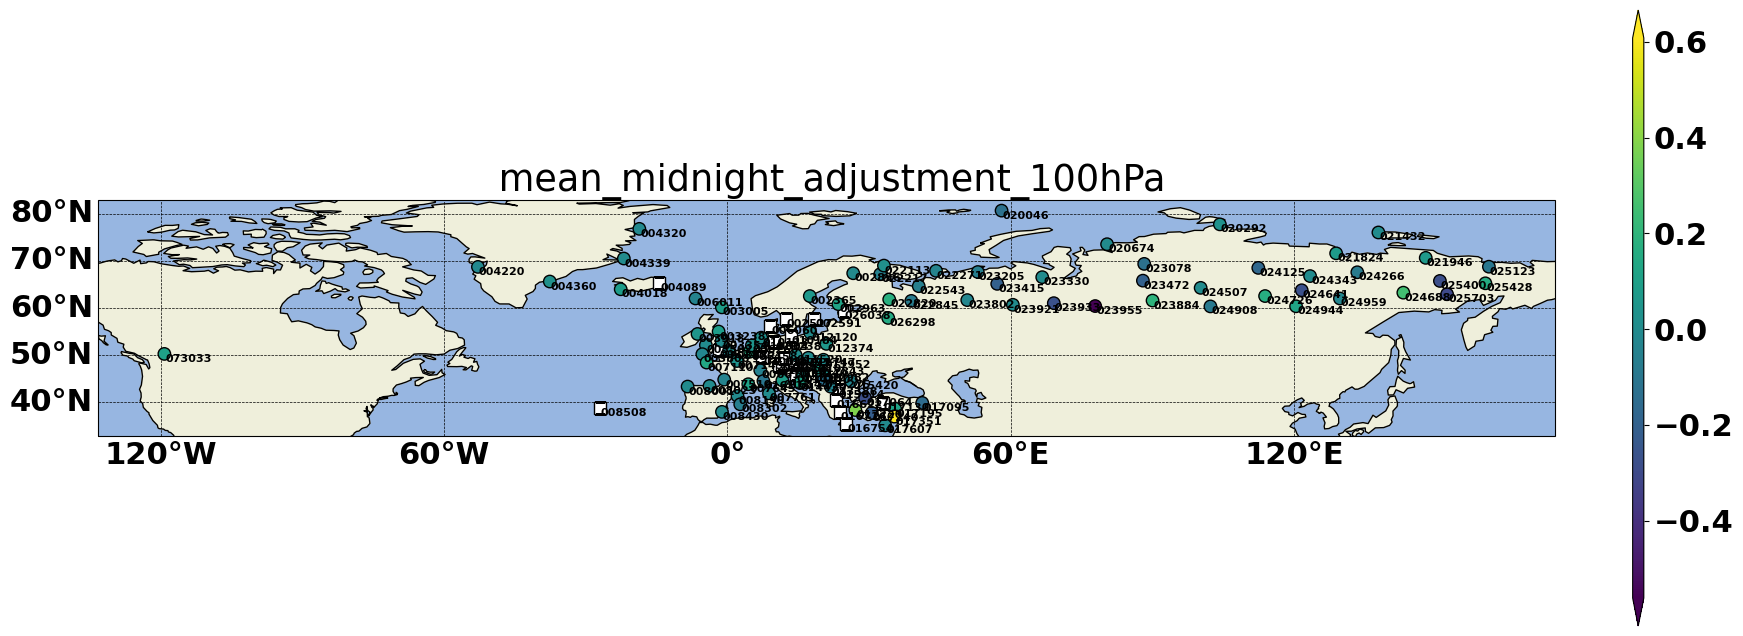

In [20]:
points(lon_list, lat_list, lable_list, mean_midnight_adjustment_list, showtitle='mean_midnight_adjustment_100hPa')

In [91]:
%debug

> /tmp/ipykernel_3558690/4083321842.py(26)<cell line: 12>()
     24         masks = {}
     25         for i in idx_d:
---> 26             masks[i] = file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]
     27             masks[i] = np.isin(masks[i],plevs)
     28             masks[i] = np.isfinite(masks[i])



ipdb>  i


'air_temperature'


ipdb>  file['observations_table']['z_coordinate'][idx_d[i][0]:idx_d[i][-1]]


*** ValueError: Invalid location identifier (invalid location identifier)


ipdb>  value_adjusted_list


[0.009986546, 0.7647835]


ipdb>  len(file['observations_table']['z_coordinate'][:])


*** ValueError: Invalid location identifier (invalid location identifier)


ipdb>  exit


In [70]:
df_old.date_time = pd.to_datetime(df_old.date_time)

In [75]:
df_old[df_old.date_time.dt.date == df_old.date_time.drop_duplicates()[0].date()]

z_coordinate           date_time  RAOBCORE_bias_estimate  air_temperature
0         1000.0 2022-01-01 00:00:00               -0.418703       233.699997
1         2000.0 2022-01-01 00:00:00                0.009908       212.699997
2         2440.0 2022-01-01 00:00:00                0.068240       213.100006
3         3000.0 2022-01-01 00:00:00                0.142482       216.500000
4         5000.0 2022-01-01 00:00:00                0.276852       213.899994
..           ...                 ...                     ...              ...
87       85000.0 2022-01-01 12:00:00               -0.212555       272.899994
88       92500.0 2022-01-01 12:00:00                0.100489       277.000000
89       95600.0 2022-01-01 12:00:00                0.133274       278.600006
90      100000.0 2022-01-01 12:00:00                0.179809       282.200012
91      100500.0 2022-01-01 12:00:00                     NaN       282.200012

[92 rows x 4 columns]

In [74]:
df_old.date_time.dt.date

0          2022-01-01
1          2022-01-01
2          2022-01-01
3          2022-01-01
4          2022-01-01
              ...    
2588284    2022-12-30
2588285    2022-12-30
2588286    2022-12-30
2588287    2022-12-30
2588288    2022-12-30
Name: date_time, Length: 2588289, dtype: object

In [9]:
for stat in glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*.nc')[:1]:
    targetfile = '/mnt/users/staff/uvoggenberger/scratch/converted_v11/trajectory_files_new/trajectory_'+str(stat.split('/')[-1])
    print(os.path.getmtime(stat))
    print(os.path.getmtime(targetfile))


1676224213.1306653
1677052550.5507061


In [16]:
len(a[a == 1])

8929

In [18]:
len(a[a == 2])

3266

In [19]:
len(a[a == 3])

0

In [20]:
len(a[a == 4])

0

In [11]:
err_list = []
for i in glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*.nc'):
    sid = i.split('/')[-1].split('_CEUAS_merged_v1.nc')[0]
    target = (glob.glob('/users/staff/uvoggenberger/scratch/converted_v11/trajectory_files_new/*'+sid+'*.nc'))
    if len(target) < 1:
        err_list.append(i)

/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02181_CEUAS_merged_v1.nc


In [2]:
ddir =  '/mnt/users/scratch/leo/scratch/converted_v11/long'
orphan_slist = glob.glob(os.path.expandvars(ddir + '/20999-*_CEUAS_merged_v1.nc'))
if len(orphan_slist) > 0:
    orphan_slnum = [i.split('/')[-1].split('_CEUAS_merged_v1.nc')[0].replace('.nc','') for i in orphan_slist]
            
print(len(orphan_slnum))

597


In [3]:
orphan_slnum

['20999-coordinate-orphan_HRT2006080518',
 '20999-coordinate-orphan_HRT2006071918',
 '20999-coordinate-orphan_HRT2006072512',
 '20999-coordinate-orphan_HRT2006071600',
 '20999-coordinate-orphan_HRT2006072306',
 '20999-coordinate-orphan_HRT2006071400',
 '20999-coordinate-orphan_HRT2006071112',
 '20999-coordinate-orphan_TEMP2006090712',
 '20999-coordinate-orphan_HRT2006072018',
 '20999-coordinate-orphan_HRT2006063000',
 '20999-coordinate-orphan_TEMP2006092312',
 '20999-coordinate-orphan_TEMP2006090100',
 '20999-coordinate-orphan_HRT2006070900',
 '20999-coordinate-orphan_HRT2006070400',
 '20999-coordinate-orphan_HRT2006092406',
 '20999-coordinate-orphan_HRT2006121612',
 '20999-coordinate-orphan_TEMP2006090706',
 '20999-coordinate-orphan_HRT2006072418',
 '20999-coordinate-orphan_TEMP2006081918',
 '20999-coordinate-orphan_HRT2006071318',
 '20999-coordinate-orphan_HRT2006102000',
 '20999-coordinate-orphan_HRT2006101712',
 '20999-coordinate-orphan_HRT2006102112',
 '20999-coordinate-orphan_TEM

In [5]:
with open('/users/staff/uvoggenberger/scratch/hug/config/active.json') as json_file:
    data = json.load(json_file)
for i in list(data.keys())[-10:]:
    print(i)


20999-coordinate-orphan_PILOT2006060118
20999-coordinate-orphan_PILOT2006030418
20999-coordinate-orphan_PILOT2006080700
20999-coordinate-orphan_HRT2006082918
20999-coordinate-orphan_PILOT2006051206
20999-coordinate-orphan_HRT2006082318
20999-coordinate-orphan_HRT2006103112
20999-coordinate-orphan_HRT2006080506
20999-coordinate-orphan_HRT2006021712
20999-coordinate-orphan_HRT2006040612


In [6]:
data['20999-coordinate-orphan_HRT2006080518']

[3363800400,
 3363800400,
 16.969999313354492,
 7.980000019073486,
 'XXK',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006080518_CEUAS_merged_v1.nc']

In [170]:
data_dir = "/mnt/users/scratch/leo/scratch/converted_v11/long"
orphan_slist = glob.glob(data_dir + '/20999-*_CEUAS_merged_v1.nc')

In [171]:
orphan_slist

['/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006080518_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006071918_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006072512_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006071600_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006072306_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006071400_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006071112_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_TEMP2006090712_CEUAS_merged_v1.nc',
 '/mnt/users/scratch/leo/scratch/converted_v11/long/20999-coordinate-orphan_HRT2006072018_CEUAS_merged_v1.nc',


In [83]:
u, c = np.unique(slnum, return_counts=True)
dup = u[c > 1]
dup

array(['0-20999-0-DREC', '20999-coordinate-orphan'], dtype='<U32')

20999-coordinate-orphan_PILOT2006060118
20999-coordinate-orphan_PILOT2006030418
20999-coordinate-orphan_PILOT2006080700
20999-coordinate-orphan_HRT2006082918
20999-coordinate-orphan_PILOT2006051206
20999-coordinate-orphan_HRT2006082318
20999-coordinate-orphan_HRT2006103112
20999-coordinate-orphan_HRT2006080506
20999-coordinate-orphan_HRT2006021712
20999-coordinate-orphan_HRT2006040612


In [139]:
np.isin('ZZXUAICE026', list(data.keys()))

array(False)

In [141]:
for string in list(data.keys()):
    if 'ZZXUAICE026' in string:
        print(string)

In [28]:
commoners = 1 # 1
power_kinetic_energy = 0 # W
stone_radius = 0.10 # m
commoners_square = 5 # ft 
round_time = 6 # s
ft_to_m = 0.3048 # m/ft
density_stone = 2515 # kg/m³
density_air = 1.2 # kg/m²
C = 0.47 # 1 - estimated sphere
g =  9.806 # m/s

short_term_power_human = 500 # W
 

volume_stone = 4/3 * (stone_radius ** 3) * np.pi # m³ 
surface_stone = 4 * np.pi * stone_radius # m²
projected_area_stone = surface_stone / 4 # m²

mass_stone = volume_stone * density_stone # kg

while((short_term_power_human * commoners) > power_kinetic_energy):

    velocity = commoners * commoners_square * ft_to_m / round_time # m/s

    kinetic_energy = 1/2 * mass_stone * (velocity ** 2)
    power_kinetic_energy = kinetic_energy / round_time
    commoners += 1

print('commoners: ', commoners)
print('kinetic_energy stone, rg: ', kinetic_energy , 'J')
print('kinetic_power stone, rg: ', power_kinetic_energy , 'W')

terminal_velocity = np.sqrt( (2 * mass_stone * g) / (C * density_air * projected_area_stone) )

kinetic_energy_terminal = 1/2 * mass_stone * (terminal_velocity ** 2)
power_kinetic_energy_terminal = kinetic_energy_terminal / round_time

print('kinetic_energy stone, ff: ', kinetic_energy_terminal , 'J')
print('kinetic_power stone, ff: ', power_kinetic_energy_terminal , 'W')

commoners:  8830
kinetic_energy stone, rg:  26490311.787032876 J
kinetic_power stone, rg:  4415051.96450548 W
kinetic_energy stone, ff:  6142.089063102235 J
kinetic_power stone, ff:  1023.6815105170391 W


In [27]:
commoners

8830